# **Project 1**

# **Link to Colab Project**
**Important: To watch the videos of the solutions, please check the project on colab.**

Link: https://colab.research.google.com/drive/1CwLzRmJy67PMd_8LKdTBTKsK2QlmxeWF?usp=sharing


#Group Members

* Alceu Emanuel Bissoto - 191077
* George Corrêa de Araújo - 191075
* Stephane de Freitas Schwarz - 211518
* Jing Yang - 262891

Our team decided to divide the solutions for each team member, being divided as:

- Monte Carlo - Alceu
- Q-Learning - George
- SARSA - Stephane
- Linear Methods - Jing

The remaining parts of the project, including the analysis, were created and revised by every team member, with equal contribution.

# Problem description

---
In this assignment, we had implemented four reinforcement learning control methods to solve the CartPole environment from the OpenAI Gym. The inverted pendulum problem consists of finding an appropriate action policy that balances a pole attached by an un-actuated joint to a cart while it moves along a frictionless horizontal track. The pendulum starts in the upright position, and the goal is to preserve it on top by applying bi-directional lateral force on the cart, in other words, increasing and reducing the cart's velocity, keeping the cart between limiting track positions. The cart speed relies on the angle the pole is pointing since the center of gravity of the pendulum increases the energy needed to move the cart.

The Cart Pole has four observation attributes at any time, randomly initialized between $\pm$ 0.05: the linear cart position $x$, cart velocity $\dot{x}$, pole angle $\theta$, and pole velocity $\dot{\theta}$. The table below shows the observation attributes limits.

| Attribute | Min. | Max. |
| :-- | :-- | :-- |
| Cart Position | - 4.8 | 4.8 
| Cart Velocity | - Inf | Inf
| Pole Angle | -24 deg | 24 deg
| Pole Angular Velocity | - Inf | Inf

\
The model simulation derives from Newtonian physics or Lagrangian methods. The following equation describes the system dynamics.

\
\begin{equation}
\ddot{x} = \frac{(I+ml^{2})(F+ml\dot{\theta}^{2}sin\theta) - gm^{2}l^{2}sin\theta cos\theta}{I(M+m)+ml^{2}(M+msin^{2}\theta)}
\end{equation}

\
\begin{equation}
\ddot{\theta} = -\frac{ml[F cos\theta + ml\dot{\theta}^{2} sin\theta.cos\theta - (M +m) g sin\theta]}{I(M+m)+ml^{2}(M+msin^{2}\theta)}
\end{equation}
\
Where $I$ is the moment of inertia, $l$ is the length of the pendulum, $m$ is the mass of the pendulum, $M$ is the cart mass, $g$ is the acceleration due to gravity, and $F$ is the force applied on the cart [[1]](http://ethesis.nitrkl.ac.in/6302/1/E-64.pdf). Knowing the model dynamics, we can conclude that Cart Pole has a deterministic environment, which means that by applying a force $F$ from a state $s$, the model can determine the next state $s'$. That force $F$ applied horizontally to the cart represents the action space and can assume one of two possible values $-f$ or $+f$ respectively left and right.

Cart pole task is episodic. An episode ends when the cart position is more than 2.4 units (the center of the cart reaches the edge of the display), or the pole angle is more than $\pm$ 12 degrees, or the amount of steps is higher than 500. By default, for every timestep taken, including the terminal one, the model returns a reward 1. The problem is solved when the reward average is higher or equal to 475 over 100 consecutive trials [[2]](https://www.google.com/url?q=https://github.com/openai/gym/blob/8e5a7ca3e6b4c88100a9550910dfb1a6ed8c5277/gym/envs/__init__.py%23L50&sa=D&ust=1608765798928000&usg=AFQjCNEjJcLV6B2yYti1uY8csySiGpCuGw).


<a name="discretization-description"></a>
#Discretization description
---

The Cartpole environment's observations contains continuous values, as described in the previous section. For the tabular methods employed (Monte Carlo, Q-Learning, and SARSA), we must discretize each observation, so its combinations compose the states of our Markov Decision Process.

Each observation attribute is binarized using a given number of bins. By using more bins, we are making our solution aware of subtler changes in the observations (by enabling a more accurate estimation of the observation space). Also, with more bins, the amount of states grows considerably, and so does the memory consumed and time of convergence of the Reinforcement Learning algorithm. 

To compose the state with the available observations, we evaluate:

$\sum_{i=0}^{k} [obs_i (n_{bins} + 1)^i]$,

where $k$ is the total number of observations, $obs_i$ is each of the observation attributes bins, and $n_{bins}$ is the defined number of bins.

Intuitively, it is as we have a $n_{bins} + 1$ base number, where each digit corresponds to an observation. Finally, we convert it back to decimal notation.

Next, we perform a random search to visit as much different states as possible using the 'raw' observations, and determine the ranges we should consider for each attribute when doing the discretization.

The minimum and maximum values reached by the random search, and that will be used for the discretization intervals are described in the table below:

| State | Min. | Max. | Disc. Min. | Disc. Max. |
| :-- | :-- | :-- |  :-- | :-- |
| Cart Position | -4.8 | 4.8 | -2.5 | 2.5 |
| Cart Velocity | -Inf | Inf | -3.2 | 3.2 |
| Pole Angle | -24 deg | 24 deg | -17 deg | 17 deg |
| Pole Angular Velocity | -Inf | Inf | -3.7 | 3.7 |

In [ ]:
import gym 
import numpy as np
environment_name = 'CartPole-v1'
env = gym.make(environment_name)

def get_action(s, w):
    return 1 if s.dot(w) >0 else 0 

def play_one_episode(env, params):
    observation = env.reset()
    done = False
    t = 0
    obs_arr = []
    while not done and t<10000:
        t+=1
        action = get_action(observation, params)
        observation, reward, done, info = env.step(action)
        obs_arr.append(observation)
        if done:
            break

    return t, obs_arr

def play_multiple_episodes(env, T, params):
    episode_lengths = np.empty(T)
    for i in range(T):
        episode_lengths[i], obs = play_one_episode(env, params)
        if i == 0:
          obs_arr = obs
        else:
          obs_arr.extend(obs)

    avg_length = episode_lengths.mean()
    return avg_length, obs_arr

def random_search(env):
    episode_lengths = []
    best = 0
    params = None
    for t in range(100):
        new_params = np.random.random(4)*2 - 1
        avg_length, obs = play_multiple_episodes(env, 100, new_params)
        episode_lengths.append(avg_length)
        if t == 0:
          obs_arr = obs
        else:
          obs_arr.extend(obs)

        if avg_length > best:
            best = avg_length
            params = new_params
  
    return obs_arr

obs_arr = random_search(env)
obs_arr = np.array(obs_arr)
print(f'Observation array: {obs_arr.shape}')

for i in range(4):
  attribute = obs_arr[:,i]
  print(f'attribute {i}:\n min: {np.min(attribute):.5f}\n max: {np.max(attribute):.5f}\n\n')

Observation array: (470489, 4)
attribute 0:
 min: -2.45528
 max: 2.45240


attribute 1:
 min: -3.33963
 max: 3.33818


attribute 2:
 min: -0.26882
 max: 0.26891


attribute 3:
 min: -3.32940
 max: 3.33359




---
# Install and import everything

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[atari] pyvirtualdisplay > /dev/null 2>&1
!pip install matplotlib memory_profiler pandas seaborn > /dev/null 2>&1

In [ ]:
import base64
import glob
import io
import locale
import logging
import math
import os
import sys
import time
from collections import namedtuple
from datetime import datetime
from typing import List

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gym import wrappers
from gym.wrappers import Monitor
from IPython import display as ipythondisplay
from IPython.display import HTML
from pyvirtualdisplay import Display
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

# from tqdm.notebook import trange
# from tqdm import trange

locale.setlocale(locale.LC_ALL, '')
sns.set_style('darkgrid')
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_context("notebook", rc={"lines.linewidth": 1.5})

%load_ext memory_profiler


# Create auxiliary functions

In [ ]:
def print_environment_info(env):
  # https://stackoverflow.com/a/52774794/14459430
  name = env.unwrapped.spec.id
  spec = gym.spec(name)

  print(f'Action Space: {env.action_space}')
  print(f'Observation Space: {env.observation_space}')
  print(f'Max Episode Steps: {spec.max_episode_steps}')
  print(f'Nondeterministic: {spec.nondeterministic}')
  print(f'Reward Range: {env.reward_range}')
  print(f'Reward Threshold: {spec.reward_threshold}\n')


"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video(episode: int=-1) -> None:
  mp4list = sorted(glob.glob('video/*.mp4'))
  if len(mp4list) > 0:
    mp4 = mp4list[episode]
    print(f'Displaying {mp4}')
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

def plot_running_avg(totalrewards, title, plot=True):
    totalrewards = np.array(totalrewards)
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    if plot:
      plt.plot(running_avg)
      plt.title(title)
      plt.show()
    return running_avg


# Function specific for SARSA
def plot_all_sarsa(stop_where, stats=None, feature_label=None, feature_values=None, smooth_factor=100):

  for idx, (values, keys, labels) in enumerate(zip(stats.values(), stats.keys(), feature_label)):

    if keys in stop_where:
        
      for idy, statistics in enumerate(values):

        smooth_rew = pd.Series(statistics[0].episode_rewards).rolling(smooth_factor, 
                                                            min_periods=smooth_factor).mean()
        try:
          plt.plot(smooth_rew, label=labels.format(feature_values[idx][idy]))
        except:
          plt.plot(smooth_rew, label=labels.format(str(feature_values[idx][idy])))
    

      plt.xlabel('Episode')
      plt.ylabel('Episode smoothed reward')
      plt.title('Running avg - varying {} | SF: {}'.format(feature_label[idx][1], smooth_factor))
      plt.legend()

  plt.show()

def multiple_plot(data, xlabel, ylabel, title, avg=True):
  # Expects data to receive [(d0, legend0), (d1, legend1), ...]
  for y in data:
    totalrewards = np.array(y[0])
    if avg:
      N = len(totalrewards)
      running_avg = np.empty(N)
      for t in range(N):
          running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
      plt.plot(running_avg, label=y[1])
    else:
      plt.plot(totalrewards, label=y[1])

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend()
  plt.show()
  
def simple_plot(data, xlabel, ylabel, title):
  plt.plot(data)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

def plot_mse(mses, features=None, title='MSE'):
  
  for idx, mse in enumerate(mses):
    plt.plot(mse, label='$λ = {:.1f}$'.format(features[idx]))

  plt.xlabel('Episode')
  plt.ylabel('mse')
  plt.title(title)
  plt.legend()


<a name="reward-functions"></a>
## **Reward Functions**
---

In this project, we have adopted three reward functions to penalize to model, aiming to boost their performance. The simplest one consists of punishing the learning algorithm when it was set done but did not reach all the steps. In this sense, the system gets a positive reward when it runs over all 500 iterations.

Similarly, the finish bonus approach considers the step to reward. To that, it verifies if the current iteration is higher than a threshold. If true, it returns a positive reward based on the floor division between the step and the threshold added by 1. Whatever the current iteration, if the steps are lower than the checkpoint (closer to the limit steps), the reward is 1.

In contrast with those methods, the last one punishes the algorithm if the pole angle is $\pm$3 degrees from the center. The general idea of the Cart Pole task is to keep the pole upright. The pole angle is one of the observation attributes that can make the task end. Given that, we decide to build a safe boundary, penalizing any angle value outside that.

In [ ]:
# rewards functions
def finish_bonus(steps, checkpoint_steps=25):
  if steps > checkpoint_steps:
    # get extra reward every checkpoint_steps
    return steps // checkpoint_steps + 1
  else:
    # get penalty for not getting to first checkpoint_steps
    # return steps - checkpoint_steps
    return 1

def finish_penalty(done_signal, steps, penalty = 500):
  if done_signal and steps < 500:
    return -penalty
  else:
    return 1

def pole_angle_based_penalty(observation, step):        
  pole_angle = observation[2]
  angle = 3 * 2 * math.pi / 360
  # If the pole is 3 degrees from de center, penalty.
  if (pole_angle < -angle) or (pole_angle > angle):    
    return -200
  return 100

# Create methods

---
## Monte Carlo Control

Monte Carlo relies on multiple random episodic plays to approximate the value function.
For every episode, we evaluate the total future reward $G_t$, accumulating the episode's rewards $R_t$ adequated by the discount factor $\gamma$:

$G_{t}=R_{t+1}+\gamma R_{t+2}+\cdots+\gamma^{T-1} R_{T}$

The value function $V(S_t)$ is updated using an incremental mean of the total future reward from the previous played episode. It is updated only after an episode is over:

$V\left(S_{t}\right) \leftarrow V\left(S_{t}\right)+\alpha\left(G_{t}-V\left(S_{t}\right)\right)$,

where $G_{t}$ is the previously calculated total future reward and $\alpha$ is the step-size. 

In [ ]:
class MonteCarlo(object):
  def __init__(self, env, num_bins=9, num_episodes=1000, N0=1, gamma=0.99, reward_mode=0, idx=[0,1,2,3]):
    self.env = env
    self.gamma = gamma
    self.num_discretization_bins = num_bins
    self.reward_mode = reward_mode
    self._state_bins = [
      # Cart position.
      self._discretize_range(-2.5, 2.5, self.num_discretization_bins),
      # Cart velocity.
      self._discretize_range(-3.2, 3.2, self.num_discretization_bins),
      # Pole angle.
      self._discretize_range(-0.3, 0.3, self.num_discretization_bins),
      # Tip velocity.
      self._discretize_range(-3.7, 3.7, self.num_discretization_bins)
    ]
    self._max_bins = max(len(bin) for bin in self._state_bins)
    self.actionSpace = [0, 1] # right or left
    self._num_actions = self.env.action_space.n 
    self.num_states = (self._max_bins + 1) ** len(self._state_bins)
    self.num_episodes = num_episodes
    self.N0 = N0
    self.idx = idx

    self.Q = np.zeros(shape=(self.num_states, self._num_actions))
    self.pairsVisited = np.zeros((len(self.Q),self._num_actions)) # N(st, at)
    self.value = np.zeros((len(self.Q),self._num_actions))        # v(s)
    self.statesVisited = np.zeros(len(self.Q))    # N(st)
    
    # initialize random policy
    self.policy = {}
    for state in range(len(self.Q)):
        self.policy[state] = np.random.choice(self.actionSpace)

    # Statistics
    self.rewardHistory = []
    self.stepHistory = []
    self.time = 0

  def _discretize_range(self, lower_bound, upper_bound, num_bins):
      return np.linspace(lower_bound, upper_bound, num_bins + 1)[1:-1]

  def discretize_state(self, observation, idx):
    def _discretize_value(value, bins):
      return np.digitize(x=value, bins=bins)

    observation = observation[idx]
    state = sum(
        _discretize_value(feature, self._state_bins[i]) * ((self._max_bins + 1) ** i)
        for i, feature in enumerate(observation)
    )
    return state
    

  def e_greedy(self, N0, Nt):
  #def evaluate_eps(N0, Nt):
    return N0 / (N0 + Nt)
  
  def exec(self):
    start = time.time()
    # Play Episodes.
    for i in range(self.num_episodes):
      statesActionsReturns = []
      memory = []
      total_reward = 0
      iters = 0
      observation = self.env.reset()
      done = False

      # Play once
      while not done:
          action = self.policy[self.discretize_state(observation, self.idx)]
          observation_, reward, done, info = self.env.step(action)
          
          if self.reward_mode == 1:
              #reward = np.digitize(x=iters, bins=self._discretize_range(0, 500, 10)) + 1
              reward = finish_bonus(iters)

          if done and iters < 500:
              reward = -500

          memory.append((self.discretize_state(observation, self.idx), action, reward))
          observation = observation_

          total_reward += reward
          iters += 1
      memory.append((self.discretize_state(observation, self.idx), action, reward))
      
      # Evaluate G for each (state,action) performed.
      G = 0
      last = True
      self.rewardHistory.append(total_reward)
      self.stepHistory.append(iters)
      statesActionsVisited = []

      for state, action, reward in reversed(memory):
          #sa = ((state), action)
          #if sa not in statesActionsVisited:
          statesActionsReturns.append((state, action, G))
          G = self.gamma * G + reward # future returns
          #statesActionsVisited.append(sa)

      statesActionsReturns.reverse()

      # Based on (state, action, G), update Q table.
      for state, action, G in statesActionsReturns:
          sa = ((state), action)
          if sa not in statesActionsVisited:
            self.statesVisited[state] += 1
            self.pairsVisited[state][action] += 1
            # statesVisited = N(s) is the number of times a state "s" was visited
            # pairsVisited = N(s,a) is the number of times an action "a" was selected when on state "s" 
            # Q(s,a) = Q(s,a) + [1/N(st, at) * (G - Q(s,a))]
            # Q(s,a) = Q(s,a) + alpha (G - Q(s,a))
            self.Q[state][action] += (1 / self.pairsVisited[state][action])*(G - self.Q[state][action])
            statesActionsVisited.append(sa)   

      listStatesVisited = [state for state, value in enumerate(self.statesVisited) if value > 0]

      for state in listStatesVisited:      
          rand = np.random.random()
          # Composing the policy
          if rand < 1 - self.e_greedy(self.N0, self.statesVisited[state]):
              values = np.array([self.Q[state][a] for a in self.actionSpace ])
              best = np.argmax(values)
              #print("BEST:", best)
              self.policy[state] = self.actionSpace[best]
          else:
              self.policy[state] = np.random.choice(self.actionSpace)
      end = time.time()
      self.time = end - start          

  def video(self):
    obs = self.env.reset()
    for _ in range(100000):
      state = self.discretize_state(obs, self.idx)
      action = self.policy[state]
      obs, reward, done, info = self.env.step(action)  
      if done:
          break
    self.env.close()
    show_video()

## Q-Learning

Q-Learning is an off-policy TD control algorithm that learns the action-value function $Q$ by successively improving its evaluations of the quality of particular actions at particular states. The core of the algorithm is a Bellman equation as a simple value iteration update, using the weighted average of the old value and the new information, represented in:

\begin{equation}
Q(S, A) \leftarrow \underbrace{Q(S, A)}_\text{old value} + \underbrace{\alpha}_{\text{learning} \\ \text{rate}} [\underbrace{R}_\text{reward} + \underbrace{\gamma}_{\text{discount} \\ \text{factor}} \underbrace{max_{a'}Q(S', a')}_{\text{max reward possible} \\ \text{from next state}} - \underbrace{Q(S, A)}_\text{old value}]
\end{equation}

where $\alpha$ is the learning rate, $R$ is the reward obtained after executing the chosen action at the current state, $max_{a'}Q(S', a')$ is the maximum reward that can be obtained from the next state (that is, using greedy policy to choose the next action), and $\gamma$ is the discount factor.

The learned action-value function $Q$ converges to $Q^{*}$, the optimal action-value function, independent of the policy being followed as long as all actions are repeatedly sampled in all states and the action-values are represented discretely [[3]](https://link.springer.com/article/10.1007/BF00992698). The policy still has an effect in that it determines which state-action pairs are visited and updated.

In [ ]:
class Agent:
  def __init__(self, env, n_bins=18, max_episodes=10_000, max_steps=10_000, additional_reward_fn=None, 
               finish_bonus_fn=None, N0=1, max_boundary_values=0, observations_to_use=[0,1,2,3], name=''):
    self._logger = logging.getLogger(__name__)
    self.action_space = env.action_space.n
    self.action_sample = env.action_space.sample
    self.additional_reward = additional_reward_fn
    self.bins_limits = []

    if type(max_boundary_values) is int:
      if max_boundary_values > 0:
        # change limits of bins
        # for i in range(env.observation_space.low.shape[0]):
        for i in observations_to_use:
          if env.observation_space.low[i] < -max_boundary_values:
            lower_boundary = -max_boundary_values
          else:
            lower_boundary = env.observation_space.low[i]

          if env.observation_space.high[i] > max_boundary_values:
            upper_boundary = max_boundary_values
          else:
            upper_boundary = env.observation_space.high[i]

          self.bins_limits.append(np.linspace(lower_boundary, upper_boundary, n_bins+1)[1:-1])
      else:
        self.bins_limits = [ np.linspace(env.observation_space.low[i], env.observation_space.high[i], n_bins+1)[1:-1]
                        # for i in range(env.observation_space.low.shape[0]) ]
                        for i in observations_to_use ]
    elif type(max_boundary_values) is list:
      for i in observations_to_use:
        self.bins_limits.append(np.linspace(max_boundary_values[i][0], max_boundary_values[i][1], n_bins+1)[1:-1])
    else:
      raise ValueError(f'Invalid max_boundary_values: {max_boundary_values}')

    self._logger.debug(f'Bins limits: {self.bins_limits}')
    print(f'Number of possible states: {n_bins ** len(observations_to_use):n}')

    self.current_episode = 0
    self.env = env
    self.finish_bonus = finish_bonus_fn
    self.max_episodes = max_episodes
    self.max_steps = max_steps
    self.name = name
    self.N0 = N0
    self.observations_to_use = tuple(observations_to_use)
    self.rewards_per_episode = np.zeros(max_episodes)
    self.steps_per_episode = np.empty(max_episodes)
    self.trained_episodes = 0
    # self.times_action_chosen_from_state = np.zeros([*([n_bins] * env.observation_space.shape[0]),
    #                                                         env.action_space.n])
    # self.times_state_visited = np.zeros([n_bins] * env.observation_space.shape[0])
    self.times_action_chosen_from_state = np.zeros([*([n_bins] * len(observations_to_use)),
                                                            env.action_space.n])
    self.times_state_visited = np.zeros([n_bins] * len(observations_to_use))
    self._logger.debug(f'times_action_chosen_from_state shape: {self.times_action_chosen_from_state.shape}')
    self._logger.debug(f'times_state_visited shape: {self.times_state_visited.shape}')
  
  def act(self, observation):
    action = self.epsilon_greedy(observation)
    indices = [np.digitize(o, b) for o, b in zip(observation, self.bins_limits)]
    indices = tuple(indices + [action])
    self.times_action_chosen_from_state[indices] += 1
    return action

  def _calculate_epsilon(self, observation):
    indices = tuple([np.digitize(o, b) for o, b in zip(observation, self.bins_limits)])
    Nst = self.times_state_visited[indices]
    return self.N0 / (self.N0 + Nst)

  def epsilon_greedy(self, observation):
    random_number = np.random.rand()
    if random_number < 1 - self._calculate_epsilon(observation):
      # choose greedy action
      indices = tuple([np.digitize(o, b) for o, b in zip(observation, self.bins_limits)])
      action = np.argmax(self.q_table[indices])
      self._logger.debug(f'Choosing greedy action: {action}')
      return action
    else:
      # choose random action
      action = self.action_sample()
      self._logger.debug(f'Choosing random action: {action}')
      return action

  def end_episode(self):
    self.current_episode += 1

  def play_one_ep(self, print_every_n_eps=1_000, info_for_last_eps=100, generate_video=False):
    # get initial observation
    observation = self.env.reset()
    # filter observation variables to use
    observation = [ observation[i] for i in range(len(observation)) if i in self.observations_to_use ]

    for step in range(self.max_steps):
      if generate_video:
        self.env.render()

      action = self.act(observation)
      old_observation = observation

      observation, reward, done, info = self.env.step(action)
      
      if self.additional_reward is not None:
        reward += self.additional_reward(step, observation)
      
      # filter observation variables to use
      observation = [ observation[i] for i in range(len(observation)) if i in self.observations_to_use ]
      
      if done:
        if self.finish_bonus is not None:
          self.update(reward + self.finish_bonus(step), old_observation, action, observation)
        else:
          self.update(reward, old_observation, action, observation)
        break
      else:
        self.update(reward, old_observation, action, observation)

    self.steps_per_episode[self.current_episode] = step

    if (self.current_episode + 1) % print_every_n_eps == 0:
      print(f'\nEpisode {self.current_episode+1} finished after {step+1} steps with total reward '
            f'{self.rewards_per_episode[self.current_episode]:.3f}')
      print(f'Avg for the last {info_for_last_eps} episodes: reward = '
            f'{self.rewards_per_episode[self.current_episode-info_for_last_eps:self.current_episode].mean():.3f}, '
            f'number of steps: '
            f'{self.steps_per_episode[self.current_episode-info_for_last_eps:self.current_episode].mean():.3f}')
      
    self.end_episode()
    return self.steps_per_episode[self.current_episode-1], self.rewards_per_episode[self.current_episode-1]

  def plot_rewards(self):
    self._plot_smooth_avg(self.rewards_per_episode[:self.current_episode], y_axis='Reward')

  def _plot_smooth_avg(self, data, y_axis='', figsize=(12, 5), smoothing_window=10):
    plt.figure(figsize=figsize)
    # plt.plot(episode_lengths)
    smoothed_data = pd.Series(data).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(smoothed_data)
    plt.xlabel('Episode')
    plt.ylabel(y_axis)
    plt.title(f'{y_axis} over Episode (Smoothed over window size {smoothing_window})')
    plt.show()

  def plot_states_visits(self, figsize=(12, 5)):
    plt.figure(figsize=figsize)
    plt.plot(self.times_state_visited.flatten())
    plt.xlabel('State')
    plt.ylabel('Times visited')
    plt.title(f'Times a state has been visited')
    plt.show()

  def plot_steps(self):
    self._plot_smooth_avg(self.steps_per_episode[:self.current_episode], y_axis='Steps')

  def update(self, reward, old_observation, chosen_action, new_observation):
    indices_old = tuple([np.digitize(o, b) for o, b in zip(old_observation, self.bins_limits)])
    self.times_state_visited[indices_old] += 1
    self.rewards_per_episode[self.current_episode] += reward


class QLearning(Agent):
  def __init__(self, env, n_bins=18, gamma=0.9, max_episodes=10_000, max_steps=10_000, additional_reward_fn=None,
               finish_bonus_fn=None, N0=1, max_boundary_values=0, observations_to_use=[0,1,2,3], low_q=0, high_q=1,
               name='QLearning'):
    super(QLearning, self).__init__(env, n_bins=n_bins, max_episodes=max_episodes, max_steps=max_steps,
                                    additional_reward_fn=additional_reward_fn, finish_bonus_fn=finish_bonus_fn, N0=N0,
                                    max_boundary_values=max_boundary_values, observations_to_use=observations_to_use,
                                    name=name)
    
    # self.q_table = np.random.uniform(low=low_q, high=high_q, size=(*([n_bins] * env.observation_space.shape[0]),
    #                                                         env.action_space.n))
    self.q_table = np.random.uniform(low=low_q, high=high_q, size=(*([n_bins] * len(self.observations_to_use)),
                                                            env.action_space.n))
    self._logger = logging.getLogger(__name__)
    
    self._logger.info(f'Q-Table shape: {self.q_table.shape}')
    self.gamma = gamma
    
  def update(self, reward, old_observation, chosen_action, new_observation):
    super().update(reward, old_observation, chosen_action, new_observation)

    indices_old = [np.digitize(o, b) for o, b in zip(old_observation, self.bins_limits)]
    indices_old = tuple(indices_old + [chosen_action])
    indices_new = tuple([np.digitize(o, b) for o, b in zip(new_observation, self.bins_limits)])

    max_next_quality = np.max(self.q_table[indices_new])
    old_quality = self.q_table[indices_old]
    alpha = 1 / self.times_action_chosen_from_state[indices_old]
    self.q_table[indices_old] += alpha * (reward + self.gamma * max_next_quality - old_quality)
    self._logger.debug(f'Updating {indices_old} from {old_quality} to {self.q_table[indices_old]}')

### Auxiliary Functions

In [ ]:
def plot_q_learning_states_visits(agents, figsize=(12, 5)):
  plt.figure(figsize=figsize)
  for agent in agents:
    plt.plot(agent.times_state_visited.flatten(), label=agent.name)
  plt.xlabel('State')
  plt.ylabel('Times visited')
  plt.title(f'Times a state has been visited')
  plt.legend()
  plt.show()


def plot_q_learning_stats(agents, title='', figsize=(12, 5), smoothing_window=10):
  fig, axis = plt.subplots(2, figsize=figsize, sharex=True)
  fig.suptitle(title)
  for agent in agents:
    lengths_smoothed = pd.Series(agent.steps_per_episode).rolling(smoothing_window, min_periods=smoothing_window).mean()
    axis[0].plot(lengths_smoothed, label=agent.name)

    rewards_smoothed = pd.Series(agent.rewards_per_episode).rolling(smoothing_window, min_periods=smoothing_window).mean()
    axis[1].plot(rewards_smoothed, label=agent.name)
  
  axis[0].set(ylabel='Steps')
  axis[1].set(ylabel='Reward')
  axis[-1].set(xlabel='Episodes')
  plt.legend()
  fig.tight_layout()
  plt.show(fig)


def run_q_agent(agent, max_episodes=10_000, print_every_n_eps=1_000, info_for_last_eps=100, generate_video=False):
  # setup logger
  logger = setup_log('warning', __name__, ['easyprocess', 'pyvirtualdisplay'])

  if generate_video:
    # create video display
    display = Display(visible=0, size=(1400, 900))
    display.start()

  # pbar = trange(max_episodes)
  # for ep in pbar:
  for ep in range(max_episodes):
    steps, reward = agent.play_one_ep(print_every_n_eps, info_for_last_eps, generate_video)
    # pbar.set_postfix({'steps': steps, 'reward': reward})

  if generate_video:
    agent.env.close()
    show_video()


def setup_log(log_level: str, name: str, logs_to_silence: List[str] = []) -> logging.Logger:
    log_level = {
        'debug': logging.DEBUG,  # 10
        'info': logging.INFO,  # 20
        'warning': logging.WARNING,  # 30
        'error': logging.ERROR,  # 40
        'critical': logging.CRITICAL,  # 50
    }[log_level]

    # add the handlers to the root logger
    logging.basicConfig(level=log_level)

    # change logger level of logs_to_silence to warning
    for other_logger in logs_to_silence:
        logging.getLogger(other_logger).setLevel(logging.WARNING)

    # create logger
    logger = logging.getLogger(__name__)
    logger.info(f'Log level: {logging.getLevelName(log_level)}')
    return logger

## SARSA(λ)

In this section, we discuss some challenging aspects and the implementation details for the Sarsa Lambda algorithm. The best parameters attained was shown in [Sarsa experiments](#sarsa-experiments) section.

As we mentioned earlier, the Cart Pole task has a continuous state space, and traditional reinforcement learning techniques, such as tabular Sarsa, requires a discrete observation space. Given that, initially, the observation attributes were discretized according to [discretization method](#discretization-description) presented. 

The tabular setting maintains a table $Q(s, a)$ for each tuple state-action and update based on the following rule:

\begin{equation}
Q(s, a) = Q(s, a) * \alpha * \delta * E(s, a)
\end{equation}

where 
\begin{equation}
\delta = reward + \gamma  * Q(s', a') - Q(s, a)
\end{equation}
and 
\begin{equation}
E(s, a) = \gamma * \lambda * E(s, a)
\end{equation}
Different from the previous algorithms, Sarsa is capable of learning the value function at the same time it interacts with the environment. This characteristic confers lower variance while performing updates than Q-learning. Nevertheless, because we estimate the $V_{\pi}$ from $S_{t+1}$, the model is biased, as a consequence the system update can be unstable.

Temporal Difference Learning methods bases their update on one or more estimated values. This process is also known as bootstrapping. Despite Q-learning can go one step ahead to perform the update, considering only the most recent information can lead to slow convergence [[5]](https://amreis.github.io/ml/reinf-learn/2017/11/02/reinforcement-learning-eligibility-traces.html). The Markov assumption says the future is independent of the past given the present. But for this, the current state needs abstract past information. In this sense, to boost the algorithm convergence, we can estimate the n-step trajectory of past state-action pairs. The Eligibility traces are typically used for this. The general idea of this technique is to propagate the current error to the past visited states.

Here we implemented the Sarsa lambda algorithm with eligibility traces. We perform a grid search to identify the best values for the parameters employed, which are:

| State | Exploration range |
| :-- | :-- |
| Gamma | [0, 0.5, 1] |
| Alpha | [Adaptative, 0.001, 0.01, 0.2, 1] | 
| Lambda | [0, 0.2, 0.4, 0.6, 0.8, 1] |
| N0 | [0.1, 1, 10, 100] |
| Disbretization bins | [5, 10, 20] |
| Observation size | [[0], [1], [2], [3], [0,1], [2,3], [0,1,2,3]] |
| Reward mode | [Based on step, check point, pole angle] |
| Epsilon | $\epsilon$-greedy based |

We adopted the same exploration schedules as Monte Carlo.

The epsilon-greedy is a simple method to deal with the exploration and exploitation dilemma [[6]](https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/). Regarding the epsilon (e.g. $\epsilon$) value, the algorithm choose between exploring or exploiting the space action. Setting the $e$ constant can negatively influence the model once the decision making is random. An alternative to this is to turn the epsilon adaptative to the number of times a state was visited. The intuition behind it is to allow the system to explore lower visited states and exploit the most visited ones.

Summarizing, Sarsa lambda can trace past state-action pairs reducing the model variance and boosting their performance, providing a fast convergence. However, the estimation update biased the model. The main disadvantage of tabular temporal difference approaches is to work with continuous observation spaces and high memory consumption. Also, tabular methods using eligibility traces are much more complex than one-step methods.

In [ ]:
class SarsaLambda(object):

  def __init__(self, n_episode=1000, epsilon=0.01, gamma=1, 
               alpha=0.2, steps=500, lamb=0.8, env=None,
               n_bins=10, idx=[0,1,2,3], N0=10, reward_fun=0):

    self.env = env

    self.gamma = gamma
    self.epsilon = epsilon
    self.alpha = alpha
    self.n_episode = n_episode
    self.steps = steps
    self.lamb = lamb
    
    self.reward_penalty_mode = reward_fun
    self.reward_fun = self.reward_function(reward_fun)    
    
    for_statistics = namedtuple('status', ['episode_size', 'episode_rewards', 'episode_epsilon', 'episode_alpha'])
    self.statistics = for_statistics(episode_size=np.zeros(n_episode),
                                     episode_rewards=np.zeros(n_episode),
                                     episode_epsilon=np.zeros(n_episode),
                                     episode_alpha=np.zeros(n_episode))

    self.done = False
    
    self.num_discretization_bins = n_bins
    self._state_bins = [
      # Cart position.
      self._discretize_range(-2.5, 2.5, self.num_discretization_bins),
      # Cart velocity.
      self._discretize_range(-3.2, 3.2, self.num_discretization_bins),
      # Pole angle.
      self._discretize_range(-0.3, 0.3, self.num_discretization_bins),
      # Tip velocity.
      self._discretize_range(-3.7, 3.7, self.num_discretization_bins)
    ]
    self._max_bins = max(len(bin) for bin in self._state_bins)

    self.n_stats = (self._max_bins + 1) ** len(self._state_bins)        
    self.n_actions = self.env.action_space.n
    self.idx = idx
    
    self.Q = np.random.uniform(low=-1, high=1, size=(self.n_stats, self.n_actions))

    self.N0 = N0
    self.Nt = np.zeros(len(self.Q))
    # self.pair_state_action = np.zeros((len(self.Q), self.n_actions))
    self.vary_alpha = alpha
    
    self.Q_mse = []

    
  def to_bin(self, value, bins):
    
    return np.digitize(x=[value], bins=bins)
    
  def reward_function(self, method=None):

    """
      Possible options:
        0 : Just to save one if return 1
        1 : step based penalty
        2 : pole angle based penalty
    """
    def none_penalty(observation, step):
      
      return 1

    def step_penalty(observation, step, check_point=25):

      if step > check_point:
        
        return step // check_point
      
      return step - check_point

    def pole_angle_based_penalty(observation, step):
        
      pole_angle = observation[2]

      angle = 3 * 2 * math.pi / 360

      # If the pole is 3 degrees from de center, penalty.
      if (pole_angle < -angle) or (pole_angle > angle):
        
        return -200

      return 100

    if method == 1:
      return step_penalty
    if method == 2:
      return pole_angle_based_penalty
    
    return none_penalty

  
  def _discretize_range(self, lower_bound, upper_bound, num_bins):
      return np.linspace(lower_bound, upper_bound, num_bins + 1)[1:-1]

  def discretize_state(self, observation, idx):
    def _discretize_value(value, bins):
      return np.digitize(x=value, bins=bins)

    observation = observation[idx]
    state = sum(
        _discretize_value(feature, self._state_bins[i]) * ((self._max_bins + 1) ** i)
        for i, feature in enumerate(observation)
    )
    return state
  
  def e_greedy(self):

    def policy(state):

      self.epsilon = self.N0 / (self.N0 + self.Nt[state])      

      explore = 1 - self.epsilon > np.random.rand()

      if (explore):
        
        best_policy = self.Q[state]
        
        return np.argmax(best_policy)
      
      return int(np.random.rand() * self.Q.shape[1])

    return policy

  def get_Q_s_a(self, state, action):

    s = self.discretize_state(state, self.idx)
    
    return self.Q[s, action]

  def exec_sarsa_lambda(self):

    # Repeat for each episode
    for e in range(self.n_episode):
      
      iters = 0
      done = False

      # E(s, a) = 0, for all s E S, a E A(s)
      E = np.zeros((self.n_stats, self.n_actions))

      # Initialize S, A
      state = self.env.reset()
      egreedy = self.e_greedy()
      action = egreedy(self.discretize_state(state, self.idx))

      # Increment state visited
      self.Nt[self.discretize_state(state, self.idx)] += 1
      # self.pair_state_action[self.discretize_state(state, self.idx), action] += 1

      # (Repeat for each step of episode)  or (S is terminate)
      while not done and iters < self.steps:

        iters += 1
        
        # Take action A, observe R, S'
        new_state, reward, done, info = self.env.step(action)
        
        self.statistics.episode_rewards[e] += reward
        
        # Increment state visited
        self.Nt[self.discretize_state(new_state, self.idx)] += 1

        # Choose A' from S' using e-greedy
        new_action = egreedy(self.discretize_state(new_state, self.idx))
        
        # Reward penalty
        reward = self.reward_fun(new_state, iters)  
        
        if done and iters < 499:            
            reward = -200    
              
        
        # Otherwise the learning rate is fixed
        if self.vary_alpha == 0:
            self.alpha = (self.N0 / (self.N0 + self.Nt[self.discretize_state(new_state, self.idx)]))
            

        # Delta = R + gamma * Q(S', A') - Q(S, A)
        delta = reward + self.gamma * self.get_Q_s_a(new_state, new_action) - self.get_Q_s_a(state, action)

        # E(S, A) = E(S, A) + 1
        discrete_state = self.discretize_state(state, self.idx)
        E[discrete_state, action] += 1 

        # For all s E S, a E A(s)
        # Q(s, a) = Q(s, a) + alpha * delta * E(s, a)
        self.Q = self.Q + self.alpha * delta * E

        # E(s, a) = gamma * lambda * E(s, a)
        E = self.gamma * self.lamb * E 

        # S = S'; A = A'
        state = new_state
        action = new_action

      self.statistics.episode_size[e] = iters
      self.statistics.episode_epsilon[e] = self.epsilon
      self.statistics.episode_alpha[e] = self.alpha
      self.Q_mse.append(self.Q)


    return self.statistics, self.Q

## Linear Function Aproximation

From the tabular methods, we saw that the bigger the number of bins the better the result. However Tabular method for state representations does not scale well with the number of states, as the computation memory does not allow the number of bins to increase infinitely. To solve this problem, we can estimate value function with function approximation.

In this project, we will estimate the value function with linear function approximation. As the Cartpole environment has two actions, we estimate the state value function for each action.

The formula for linear value function approximation is as follows [[3]](https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf):
\begin{equation}
\hat{v}(S, \mathbf{w})=\mathbf{x}(S)^{\top} \mathbf{w}=\sum_{j=1}^{n} \mathbf{x}_{j}(S) \mathbf{w}_{j},
\end{equation}

in which $\hat{v}()$ is the estimated value function, $S$ represents a state, $\mathbf{x}()$ is a feature transformer that transforms a state to a feature representation, and $w$ is the weight for the linear function approximator.

The objective function $J()$ is to minimize the the mean squared error of estimated value function and the true value function, the formula is as follows:
\begin{equation}
J(\mathbf{w})=\mathbb{E}_{\pi}\left[\left(v_{\pi}(S)-\mathbf{x}(S)^{\top} \mathbf{w}\right)^{2}\right],
\end{equation}

where $\pi$ represents a policy.

## Feature Transformation
In the formula for linear value function approximation, we have function $\mathbf{x}(S)$ that transforms a state representation to another feature representation. We choose to use Radial basis function (RBF) kernel as the feature transformer.  
The reasons we choose RBF kernels are [[4]](http://incompleteideas.net/book/first/ebook/node88.html):  

*  They provide non-linearity to the original states features
*  They produce smooth and differentiable features to the function approximator.

In the end, we decided to use four kernels with $\sigma = 0.05, 0.1, 0.5, 1.0$, each one has 1000 examplars.

## SGD Regression
To minimize the error, we use gradient descent, which is calculated as:

\begin{aligned}
\Delta \mathbf{w} &=\alpha\left(v_{\pi}(S)-\hat{v}(S, \mathbf{w})\right) \nabla_{\mathbf{w}} \hat{v}(S, \mathbf{w}), \\
\nabla_{\mathbf{w}} \hat{v}(S, \mathbf{w}) &=\mathbf{x}(S). 
\end{aligned}

where $\alpha$ is the learning rate for gradient descent. As the weights are updated every step, it is Stochastic Gradient Descent (SGD).

To update the weights, we need to know the true value function $v_{\pi}(S)$. However it is not feasible to obtain this, so we need to substitute $v_{\pi}(S)$ with an estimated value. For the three algorithms, we have different way of estimation [[3]](https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf).

*   Monte carlo

The estimation is the return $G_t$, so the updating rule is: 

\begin{equation}
\Delta \mathbf{w}=\alpha\left(G_{t}-\hat{v}\left(S_{t}, \mathbf{w}\right)\right) \nabla_{\mathbf{w}} \hat{v}\left(S_{t}, \mathbf{w}\right).
\end{equation}

*   TD(0)

The estimation is $R_{t+1}+\gamma \hat{v}\left(S_{t+1}, \mathbf{w}\right)$, and the updating rule is: 

\begin{equation}
\Delta \mathbf{w}=\alpha\left(R_{t+1}+\gamma \hat{v}\left(S_{t+1}, \mathbf{w}\right)-\hat{v}\left(S_{t}, \mathbf{w}\right)\right) \nabla_{\mathbf{w}} \hat{v}\left(S_{t}, \mathbf{w}\right).
\end{equation}

*   TD($\lambda$)

The estimation is: $\lambda \text { -return } G_{t}^{\lambda}$. We choose backward view, so the updating rule is:

\begin{aligned}
\delta_{t} &=R_{t+1}+\gamma \hat{v}\left(S_{t+1}, \mathbf{w}\right)-\hat{v}\left(S_{t}, \mathbf{w}\right), \\
E_{t} &=\gamma \lambda E_{t-1}+\mathbf{x}\left(S_{t}\right), \\
\Delta \mathbf{w} &=\alpha \delta_{t} E_{t}.
\end{aligned}

Except for monte carlo, TD(0) and TD($\lambda$) are not truely gradient descent, so they are called semi-gradient descent.

In [ ]:
class SGDRegressor:
  '''
  Stochastic gradient descent for linear regression
  '''
  def __init__(self, D):
    # weight initialization
    self.w = np.random.randn(D) / np.sqrt(D)

  def partial_fit(self, X, Y, lr):
    # stochastic gradient descent
    self.w += lr*(Y - X.dot(self.w)).dot(X)

  def partial_fit_sarsa(self, X, Y, lr, eligibility):
    # stochastic gradient descent with eligibility for sarsa(lambda)
    self.w += lr*(Y - X.dot(self.w))*eligibility

  def predict(self, X):
    return X.dot(self.w)

In [ ]:
class FeatureTransformer:
  def __init__(self, env):
    # observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
    # state samples are poor, b/c you get velocities --> infinity
    observation_examples = np.random.random((20000, 4))*2 - 1
    scaler = StandardScaler()
    scaler.fit(observation_examples)

    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=0.05, n_components=1000)),
            ("rbf2", RBFSampler(gamma=1.0, n_components=1000)),
            ("rbf3", RBFSampler(gamma=0.5, n_components=1000)),
            ("rbf4", RBFSampler(gamma=0.1, n_components=1000))
            ])
    feature_examples = featurizer.fit_transform(scaler.transform(observation_examples))

    self.dimensions = feature_examples.shape[1]
    self.scaler = scaler
    self.featurizer = featurizer

  def transform(self, observations):
    scaled = self.scaler.transform(observations)
    return self.featurizer.transform(scaled)

In [ ]:
class LinearModel:
  '''
  Linear regression model
  '''
  def __init__(self, env, feature_transformer):
    self.env = env
    self.models = []
    self.feature_transformer = feature_transformer
    for i in range(env.action_space.n): 
      # each action has one state value function
      model = SGDRegressor(feature_transformer.dimensions)
      self.models.append(model)

  def predict(self, s):
    X = self.feature_transformer.transform(np.atleast_2d(s))
    result = np.stack([m.predict(X) for m in self.models]).T
    return result

  def update(self, s, a, G, alpha):
    X = self.feature_transformer.transform(np.atleast_2d(s))
    self.models[a].partial_fit(X, [G], alpha)

  def sample_action(self, s, eps):
    # epsilon greedy policy
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.predict(s))


class SarsaModel:
  '''
  Linear regression model for sarsa(lambda)
  '''
  def __init__(self, env, feature_transformer):
    self.env = env
    self.models = []
    self.feature_transformer = feature_transformer

    D = feature_transformer.dimensions
    self.eligibilities = np.zeros((env.action_space.n, D))
    for i in range(env.action_space.n):
      model = SGDRegressor(D)
      self.models.append(model)

  def predict(self, s):
    X = self.feature_transformer.transform(np.atleast_2d(s))
    result = np.stack([m.predict(X) for m in self.models]).T
    return result

  def update(self, s, a, G, alpha, gamma, lambda_):
    X = self.feature_transformer.transform(np.atleast_2d(s))
    self.eligibilities *= gamma*lambda_
    self.eligibilities[a] += X[0]
    self.models[a].partial_fit_sarsa(X, [G], alpha, self.eligibilities[a])

  def sample_action(self, a, eps):
    # epsilon greedy policy
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      return a

### Monte Carlo Control

Monte Carlo control methods can be divided into on-policy and off-policy methods. In on-policy method,  the behavior policy and estimation policy are both e-greedy policy; while for off-policy, the behavior policy is e-greedy, but estimation policy is just greedy policy.

#### Monte Carlo On-policy

In [ ]:
def play_one_mc_on(env, model, eps, gamma, alpha, reward_mode = 0):
    '''
      monte carlo on-policy
    '''
    observation = env.reset()
    done = False
    totalreward = 0
    memory = []
    iters = 0
    loss = 0
    while not done:

        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        # if reward_mode == 0:
        #   reward = finish_penalty(done, iters, 500)

        if reward_mode == 1:
          reward = finish_bonus(iters, 1)

        if done and iters < 500:
          reward = -500
        totalreward += reward


        iters = iters + 1

        memory.append((prev_observation, action, reward))

    #print("MEMORY:", memory)
    G = 0
    statesActionsReturns = []
    # last = True
    for state, action, reward in reversed(memory):
        # if last:
        #     last = False
        # else:
        statesActionsReturns.append((state, action, G))
        G = gamma*G + reward

    statesActionsReturns.reverse()

    for state, action, G in statesActionsReturns:
      action = model.sample_action(state, eps) # perform e-greedy policy
      model.update(state, action, G, alpha) # policy updating (SGD)
      loss += (np.square(model.predict(prev_observation) - G)).mean()    

    loss = loss/iters

    return iters, totalreward, loss

#### Monte Carlo Off-policy

In [ ]:
def play_one_mc_off(env, model, eps, gamma, alpha, reward_mode = 0):
    '''
      monte carlo off-policy
    '''
    observation = env.reset()
    done = False
    totalreward = 0
    memory = []
    iters = 0
    loss = 0
    while not done:

        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        # if reward_mode == 0:
        #   reward = finish_penalty(done, iters, 500)

        if reward_mode == 1:
          reward = finish_bonus(iters, 1)

        if done and iters < 500:
          reward = -500
        totalreward += reward


        iters = iters + 1

        memory.append((prev_observation, action, reward))

    #print("MEMORY:", memory)
    G = 0
    statesActionsReturns = []
    # last = True
    for state, action, reward in reversed(memory):
        # if last:
        #     last = False
        # else:
        statesActionsReturns.append((state, action, G))
        G = gamma*G + reward

    statesActionsReturns.reverse()

    for state, action, G in statesActionsReturns:
      # policy updating (SGD)
      action = np.argmax(model.predict(state))
      model.update(state, action, G, alpha) 
      loss += (np.square(model.predict(prev_observation) - G)).mean()
    
    loss = loss/iters

    return iters, totalreward, loss

In [ ]:
def play_many_mc(env, mc_model, gamma, alpha, policy = 'off', reward_mode = 0, N = 1000, print_info = True):
  totalrewards = np.empty(N)
  totalsteps = np.empty(N)
  totallosses = np.empty(N)

  t = 1.0
  for n in range(N):
    if n % 100 == 0:
      t += 0.001
    alpha = alpha / t # learning rate decay
    eps = 1.0/np.sqrt(n+1) # rapid epsilon decay
    if policy == 'off':
      steps, totalreward, loss = play_one_mc_off(env, mc_model, eps, gamma, alpha, reward_mode)
    else:
      steps, totalreward, loss = play_one_mc_on(env, mc_model, eps, gamma, alpha, reward_mode)
    totalrewards[n] = totalreward
    totalsteps[n] = steps
    totallosses[n] = loss

    if n % 500 == 0 and print_info:
      print("episode:", n, "total reward:", totalreward, "total steps:", steps, "eps:", eps, "avg steps (last 100):", totalsteps[max(0, n-100):(n+1)].mean())

  return totalrewards, totalsteps, totallosses

### Q-Learning

In [ ]:
def play_one_qlearning(env, model, eps, gamma, alpha, reward_mode=0):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0
  loss = 0

  while not done:
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    # if reward_mode == 0:
        # reward = finish_penalty(done, iters, 500)

    if reward_mode == 1:
        reward = finish_bonus(iters)
      
    if done and iters < 500:
        reward = -500

    # update the model
    next = model.predict(observation)
    # print(next.shape)
    # assert(next.shape == (1, env.action_space.n))
    
    G = reward + gamma*np.max(next)
    model.update(prev_observation, action, G, alpha)
    loss += (np.square(model.predict(prev_observation) - G)).mean()

    totalreward += reward
    iters += 1

  loss = loss/iters

  return iters, totalreward, loss

In [ ]:
def play_many_ql(env, q_model, gamma, alpha, reward_mode = 0, N = 1000, print_info = True):
  totalrewards = np.empty(N)
  totalsteps = np.empty(N)
  totallosses = np.empty(N)

  t = 1.0
  for n in range(N):
    if n % 100 == 0:
      t += 0.001
    alpha = alpha / t
    eps = 1.0/np.sqrt(n+1)
    steps, totalreward, loss = play_one_qlearning(env, q_model, eps, gamma, alpha, reward_mode)
    totalrewards[n] = totalreward
    totalsteps[n] = steps
    totallosses[n] = loss

    if n % 500 == 0 and print_info:
      print("episode:", n, "total reward:", totalreward, "total steps:", steps, "eps:", eps, "avg steps (last 100):", totalsteps[max(0, n-100):(n+1)].mean())

  return totalrewards, totalsteps, totallosses

### SARSA(λ)

In [ ]:
def play_one_sarsa(env, model, eps, gamma, lambda_, alpha, reward_mode=0):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    loss = 0

    action = np.argmax(model.predict(observation))
    action = model.sample_action(action, eps)
    while not done:
        prev_observation = observation
        prev_action = action
        observation, reward, done, _ = env.step(action)

        action = np.argmax(model.predict(observation))
        action = model.sample_action(action, eps)
        
        # if reward_mode == 0:
            # reward = finish_penalty(done, iters, 500)

        if reward_mode == 1:
            reward = finish_bonus(iters)
          
        if done and iters < 500:
            reward = -500

        # update the model
        next = model.predict(observation)
        # print(next.shape)
        assert(next.shape == (1, env.action_space.n))
        # print(next)
        G = reward + gamma*next[0][action]
        model.update(prev_observation, prev_action, G, alpha, gamma, lambda_)
        loss += (np.square(model.predict(prev_observation) - G)).mean()

        totalreward += reward
        iters += 1
    loss = loss/iters

    return iters, totalreward, loss

In [ ]:
def play_many_sarsa(env, sarsa_model, gamma, lbd, alpha, reward_mode = 0, N = 1000, print_info = True):
  totalrewards = np.empty(N)
  totalsteps = np.empty(N)
  totallosses = np.empty(N)

  t = 1.0
  for n in range(N):
    if n % 100 == 0:
      t += 0.001
    alpha = alpha / t
    eps = 1.0/np.sqrt(n+1)
    steps, totalreward, loss = play_one_sarsa(env, sarsa_model, eps, gamma, lbd, alpha, reward_mode)
    totalrewards[n] = totalreward
    totalsteps[n] = steps
    totallosses[n] = loss

    if n % 500 == 0 and print_info:
      print("episode:", n, "total reward:", totalreward, "total steps:", steps, "eps:", eps, "avg steps (last 100):", totalsteps[max(0, n-100):(n+1)].mean())

  return totalrewards, totalsteps, totallosses

For every algorithm in Function Approximation, we fixed the learning rate decay and epsilon decay (in e-greedy).
 

*   Learning rate decay: $\alpha: = \alpha / (1+(n\%100)/1000)$;
*   Epsilon decay: $\epsilon = 1/\sqrt(n+1)$;

where $n$ represents $n$th episodes.



# Create Environment

In [ ]:
# available environments
# print(sorted([ e.id for e in gym.envs.registry.all() ]))

In [ ]:
# https://gym.openai.com/envs/Breakout-ram-v0/
environment_name = 'CartPole-v1'
env = wrap_env(gym.make(environment_name))
print_environment_info(env)

display = Display(visible=0, size=(1400, 900))
display.start()

Action Space: Discrete(2)
Observation Space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Max Episode Steps: 500
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 475.0



# Run Algorithms

## Monte Carlo Control

### Hyperparameter decision

We perform a grid search over reward mode, N0, and gamma parameters:

| State | Exploration range |
| :-- | :-- |
| Gamma | [0, 0.5, 0.9, 1] |
| N0 | [0.1, 1, 10, 100] |
| Disbretization bins | [5, 10, 20] |

**We consider the average steps in the last 100 episodes to measure performance.**

Next, with the optimal hyperparameters found, we perform analysis over the observation attributes, number of bins for discretization, and the variance over runs with the same hyperparameters.



In [ ]:
num_episodes = 1000

runs = {}
for reward_mode in [0, 1]:
  for N0 in [0.1, 1, 10, 100]:
    for gamma in [0, 0.5, 0.9, 1]:
      env = wrap_env(gym.make(environment_name))
      print('Running reward mode ' + str(reward_mode) + ', N0:' + str(N0) + ', gamma:' + str(gamma))
      mc = MonteCarlo(env, gamma=gamma, num_episodes=num_episodes, reward_mode=reward_mode, N0=N0)
      mc.exec()
      runs['rm{:.0f}n0{:05.1f}gamma{:.1f}'.format(float(reward_mode),float(N0),float(gamma))] = mc

Running reward mode 0, N0:0.1, gamma:0
Running reward mode 0, N0:0.1, gamma:0.5
Running reward mode 0, N0:0.1, gamma:0.9
Running reward mode 0, N0:0.1, gamma:1
Running reward mode 0, N0:1, gamma:0
Running reward mode 0, N0:1, gamma:0.5
Running reward mode 0, N0:1, gamma:0.9
Running reward mode 0, N0:1, gamma:1
Running reward mode 0, N0:10, gamma:0
Running reward mode 0, N0:10, gamma:0.5
Running reward mode 0, N0:10, gamma:0.9
Running reward mode 0, N0:10, gamma:1
Running reward mode 0, N0:100, gamma:0
Running reward mode 0, N0:100, gamma:0.5
Running reward mode 0, N0:100, gamma:0.9
Running reward mode 0, N0:100, gamma:1
Running reward mode 1, N0:0.1, gamma:0
Running reward mode 1, N0:0.1, gamma:0.5
Running reward mode 1, N0:0.1, gamma:0.9
Running reward mode 1, N0:0.1, gamma:1
Running reward mode 1, N0:1, gamma:0
Running reward mode 1, N0:1, gamma:0.5
Running reward mode 1, N0:1, gamma:0.9
Running reward mode 1, N0:1, gamma:1
Running reward mode 1, N0:10, gamma:0
Running reward mode 1,

In [ ]:
# Decide what's the best hyperparameters
maximum_avg = 0
best_key = ''
for key, value in runs.items():
  run_avg = plot_running_avg(runs[key].stepHistory, "", plot=False)
  print("reward mode: {}, N0: {}, Gamma: {} -> Average performance: {}".format(int(key[2]), float(key[5:10]), float(key[15:]), run_avg[-1]))
  if run_avg[-1] > maximum_avg:
    maximum_avg = run_avg[-1]
    best_key = key

best_rm = int(best_key[2])
best_n0 = float(best_key[5:10])
best_gamma = float(best_key[15:])

print("------------------------------------------------")
print("------------------------------------------------")
print('Best Reward Mode:', best_rm)
print('Best N0:', best_n0)
print('Best Gamma:', best_gamma)

reward mode: 0, N0: 0.1, Gamma: 0.0 -> Average performance: 38.68316831683168
reward mode: 0, N0: 0.1, Gamma: 0.5 -> Average performance: 266.51485148514854
reward mode: 0, N0: 0.1, Gamma: 0.9 -> Average performance: 125.39603960396039
reward mode: 0, N0: 0.1, Gamma: 1.0 -> Average performance: 302.5742574257426
reward mode: 0, N0: 1.0, Gamma: 0.0 -> Average performance: 9.584158415841584
reward mode: 0, N0: 1.0, Gamma: 0.5 -> Average performance: 362.5247524752475
reward mode: 0, N0: 1.0, Gamma: 0.9 -> Average performance: 190.75247524752476
reward mode: 0, N0: 1.0, Gamma: 1.0 -> Average performance: 400.73267326732673
reward mode: 0, N0: 10.0, Gamma: 0.0 -> Average performance: 10.029702970297029
reward mode: 0, N0: 10.0, Gamma: 0.5 -> Average performance: 181.04950495049505
reward mode: 0, N0: 10.0, Gamma: 0.9 -> Average performance: 166.66336633663366
reward mode: 0, N0: 10.0, Gamma: 1.0 -> Average performance: 399.38613861386136
reward mode: 0, N0: 100.0, Gamma: 0.0 -> Average per

In [ ]:
time_spent = np.array([value.time for key, value in runs.items()])
print("To perform the hyperparameter decision, we ran {} experiments, with time ranging from {} to {}, and averaging {} seconds.".format(len(time_spent), time_spent.min(), time_spent.max(), time_spent.mean()))

To perform the hyperparameter decision, we ran 32 experiments, with time ranging from 7.337491512298584 to 80.95155119895935, and averaging 36.318503856658936 seconds.


In [ ]:
# Video of the best run in the hyperparameter search
runs[best_key].video()

Displaying video/openaigym.video.49.57.video000729.mp4


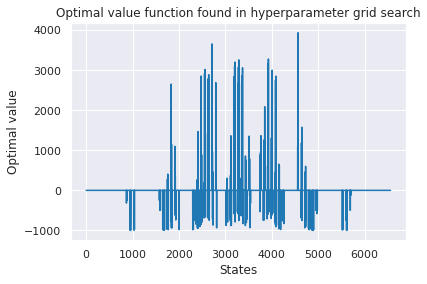

In [ ]:
optim_val = np.max(runs[best_key].Q, axis=1)
optim_val = optim_val.tolist()
# Q* plot
simple_plot(optim_val, 'States', 'Optimal value', 'Optimal value function found in hyperparameter grid search')

### Analysis

Next, using the best parameters found in the previous experiments, we show and discuss plots of step and reward per episode to evaluate the influence on performance when:
- Using different combinations of the observation attributes (instead of using them all).
- Using different number of bins in the discretization method, and how it affects the space size.
- Keeping all hyperparameters the same to measure the effects of stochasticity in the solution.

The analysis comes after the correspondent code cell.

Idx: [0]
Idx: [1]
Idx: [2]
Idx: [3]
Idx: [0, 1]
Idx: [3, 0]
Idx: [3, 1]
Idx: [3, 2]
Idx: [0, 1, 2, 3]


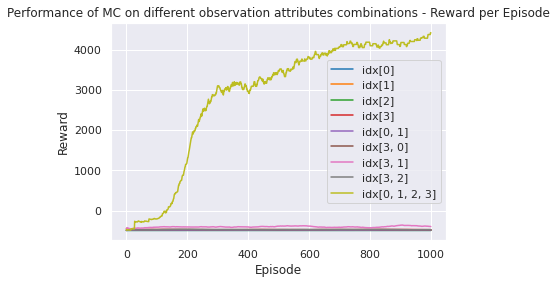

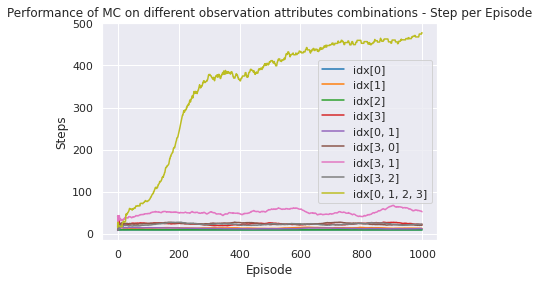

In [ ]:
# Evaluate the influence of using different observation attributes to find the solution:
runs_idx = {}
for idx in [[0], [1], [2], [3], [0,1], [3,0], [3,1], [3,2], [0,1,2,3]]:
    env = wrap_env(gym.make(environment_name))
    print('Idx: ' + str(idx))
    mc = MonteCarlo(env, idx=idx, num_episodes=num_episodes, reward_mode=best_rm, N0=best_n0, gamma=best_gamma)
    mc.exec()
    runs_idx['idx'+str(idx)] = mc

multiple_plot([(value.rewardHistory, str(key)) for key, value in runs_idx.items()], 'Episode', 'Reward', 'Performance of MC on different observation attributes combinations - Reward per Episode')
multiple_plot([(value.stepHistory, str(key)) for key, value in runs_idx.items()], 'Episode', 'Steps', 'Performance of MC on different observation attributes combinations - Step per Episode')

As expected, using all observation attributes leads to convergence of the solution. When we consider individual attributes only, we achieve the best performance for attribute 3 (Pole Angular Velocity). Intuitivelly, the solution is achieved if the control algorithm succesfully manage the pole angular velocity, making it as low as possible. 

Curiously, the performance only improves noticeably when combining attribute 3 (Pole Angular Velocity) and 1 (Cart Velocity). All the other pair combinations using attribute 3 did not improve the control. Our hypothesis is that by having access to the cart velocity, the control algorithm can avoid moving repeatedly to the same side, which would lead to an increase of cart velocity and on the pole angular velocity. 

num_bins: 5
When using 5 bins, the amount of states considered is 625.
num_bins: 10
When using 10 bins, the amount of states considered is 10000.
num_bins: 20
When using 20 bins, the amount of states considered is 160000.


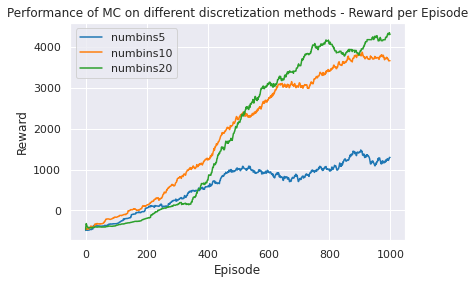

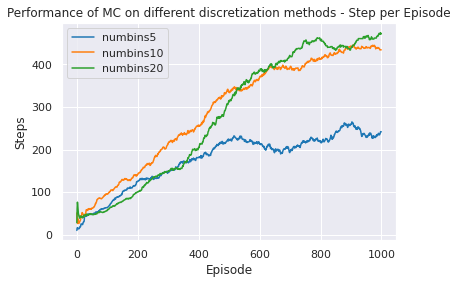

In [ ]:
# Evaluate the influence of using different number of bins on the discretization process:
runs_numbins = {}
for num_bins in [5, 10, 20]: 
    env = wrap_env(gym.make(environment_name))
    print('num_bins: ' + str(num_bins))
    mc = MonteCarlo(env, num_bins=num_bins, num_episodes=num_episodes, reward_mode=best_rm, N0=best_n0, gamma=best_gamma)
    mc.exec()
    runs_numbins['numbins'+str(num_bins)] = mc
    print("When using {} bins, the amount of states considered is {}.". format(num_bins, mc.num_states))

multiple_plot([(value.rewardHistory, str(key)) for key, value in runs_numbins.items()], 'Episode', 'Reward', 'Performance of MC on different discretization methods - Reward per Episode')
multiple_plot([(value.stepHistory, str(key)) for key, value in runs_numbins.items()], 'Episode', 'Steps', 'Performance of MC on different discretization methods - Step per Episode')

Next, we evaluated the effect of trying different number of bins in the discretization process. Intuitivelly, the bigger the number of bins, the better the state space is described, and the better the solution would be. Our initial guess maintained. However, the impact of increasing the number of bins was a lot subtler than we expected. 

If we look at how the number of states grow by increasing the number of bins, this is even more surprising:

| Number of bins | Number of states | 
| :-- | :-- | 
| 5 | 625 | 
| 10 | 10,000 | 
| 20 | 160,000 |

The 150,000 states that were created when using 20 bins instead of 10 did not help nearly as much as we expected. It means that the computational cost of the solution with 10 bins is a lot less with the one with 20 bins, since it can converged making use with 6.25% of the number of states (which affects the size of memory consumed and operations evaluated.)

Only when using 5 bins, the solution did not converge in 1000 steps.

random: 0
random: 1
random: 2
random: 3
random: 4
random: 5
random: 6
random: 7
random: 8
random: 9


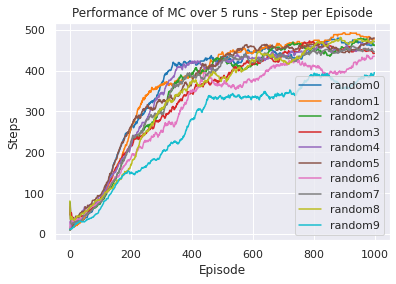

In [ ]:
# Evaluate the variance over different runs using the same parameters:
runs_random = {}
for random in range(10): 
    env = wrap_env(gym.make(environment_name))
    print('random: ' + str(random))
    mc = MonteCarlo(env, num_episodes=num_episodes, reward_mode=best_rm, N0=best_n0, gamma=best_gamma)
    mc.exec()
    runs_random['random'+str(random)] = mc
    
multiple_plot([(value.stepHistory, str(key)) for key, value in runs_random.items()], 'Episode', 'Steps', 'Performance of MC over 5 runs - Step per Episode')

Finally, we noticed that the performance of our experiments were varying significantly in between runs, making analysis incosistent in some cases. In this last experiment we want to analyse the curves of ten runs using the exact same hyperparameters. 

Because of time constraints, we could not consider the stochasticity of the method when analysing the previous aspects. To perform the hyperparameter decision, we ran 32 experiments, with time ranging from 7.34 to 80.95, and averaging 36.32 seconds.

The plot shows that even when using the same hyperparameters, the solution's step per episode ranges approximately from 400 to 500. 

### Advantages
- Good convergance

### Disadvantages
- Must wait until end of episode before return is known
- High variance

## Q-Learning

To find the best values for the parameters, we freeze all other parameters and variate one according to the given table:

| Variable | Exploration range | Description |
| :-- | :-- | :-- |
| Number of Bins | 5, 10, 20, 30 | Bins used for discretization of each observation variable |
| N0 | 0.1, 0.5, 1, 10, 100 | Different N0 constants |
| $\gamma$ | 0.1, 0.5, 0.9, 0.999 | Discount factor to weight the next max reward obtainable |
| Additional Reward | None, Step Based, Pole Angle Penalty | Additional reward besides the reward given by the environment |
| Finishing Reward | None, Step Based, High Penalty | Additional reward given after finishing an episode |
| Observation Slices | [0, 1, 2, 3], [1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2], [0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3], [0], [1], [2], [3] | Which variables from observation should the agent consider |
| Q-table Initialization | -1 to 1, 0 to 1, all zero | Range of values used to initialize the Q-table |

### Setting variables

In [ ]:
info_for_last_eps = 100
max_episodes = 1_000
max_steps = 1_000
print_every_n_eps = 250

### Testing Different Numbers of Bins

In [ ]:
agents_with_different_bins = []
max_boundary_values = [(-2.5, 2.5), (-3.2, 3.2), (-0.3, 0.3), (-3.7, 3.7)]

In [ ]:
%memit agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values, n_bins=5, name='5 bins')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_bins.append(agent)

Number of possible states: 625
Number of possible states: 625
Number of possible states: 625
peak memory: 331.25 MiB, increment: 0.00 MiB

Episode 250 finished after 26 steps with total reward 26.000
Avg for the last 100 episodes: reward = 48.450, number of steps: 47.450

Episode 500 finished after 58 steps with total reward 58.000
Avg for the last 100 episodes: reward = 48.240, number of steps: 47.240

Episode 750 finished after 35 steps with total reward 35.000
Avg for the last 100 episodes: reward = 44.850, number of steps: 43.850

Episode 1000 finished after 93 steps with total reward 93.000
Avg for the last 100 episodes: reward = 45.770, number of steps: 44.770


In [ ]:
%memit agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values, n_bins=10, name='10 bins')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_bins.append(agent)

Number of possible states: 10,000
Number of possible states: 10,000
Number of possible states: 10,000
peak memory: 332.38 MiB, increment: 0.00 MiB

Episode 250 finished after 51 steps with total reward 51.000
Avg for the last 100 episodes: reward = 58.480, number of steps: 57.480

Episode 500 finished after 30 steps with total reward 30.000
Avg for the last 100 episodes: reward = 53.590, number of steps: 52.590

Episode 750 finished after 62 steps with total reward 62.000
Avg for the last 100 episodes: reward = 56.760, number of steps: 55.760

Episode 1000 finished after 62 steps with total reward 62.000
Avg for the last 100 episodes: reward = 53.560, number of steps: 52.560


In [ ]:
%memit agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values, n_bins=20, name='20 bins')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_bins.append(agent)

Number of possible states: 160,000
Number of possible states: 160,000
Number of possible states: 160,000
peak memory: 332.38 MiB, increment: 0.00 MiB

Episode 250 finished after 51 steps with total reward 51.000
Avg for the last 100 episodes: reward = 39.590, number of steps: 38.590

Episode 500 finished after 17 steps with total reward 17.000
Avg for the last 100 episodes: reward = 41.330, number of steps: 40.330

Episode 750 finished after 22 steps with total reward 22.000
Avg for the last 100 episodes: reward = 44.970, number of steps: 43.970

Episode 1000 finished after 60 steps with total reward 60.000
Avg for the last 100 episodes: reward = 56.520, number of steps: 55.520


In [ ]:
%memit agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values, n_bins=30, name='30 bins')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_bins.append(agent)

Number of possible states: 810,000
Number of possible states: 810,000
peak memory: 360.88 MiB, increment: 28.50 MiB

Episode 250 finished after 50 steps with total reward 50.000
Avg for the last 100 episodes: reward = 31.130, number of steps: 30.130

Episode 500 finished after 46 steps with total reward 46.000
Avg for the last 100 episodes: reward = 36.780, number of steps: 35.780

Episode 750 finished after 44 steps with total reward 44.000
Avg for the last 100 episodes: reward = 40.280, number of steps: 39.280

Episode 1000 finished after 51 steps with total reward 51.000
Avg for the last 100 episodes: reward = 38.870, number of steps: 37.870


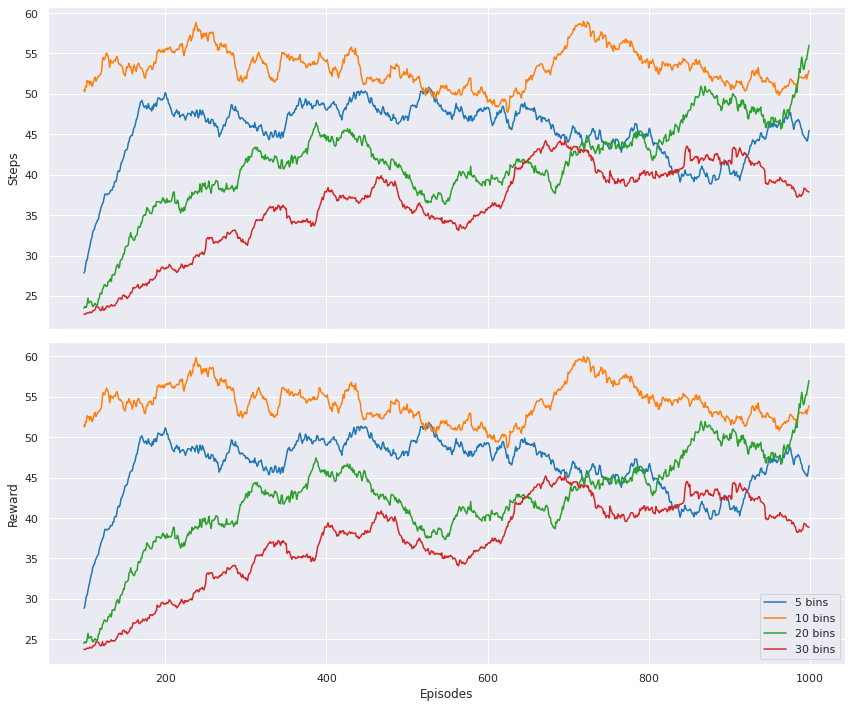

In [ ]:
plot_q_learning_stats(agents_with_different_bins, figsize=(12,10), smoothing_window=100)

It makes sense to expect that the more number of bins we use the better is the result, since the state space is more precisely described. But it seems not to be the case, as we can see in the graphic above. Using 10 bins to represent each observation variable achieves greater number of steps as the number of episodes increase. This indicates that there is a turning point whether the more bins we use decreases the performance because it increases the number of possible states, requiring more exploration. To test this hypothesis, we will run the same experiments, increasing the number of episodes to 10,000.

In [ ]:
agents_with_different_bins = []
max_boundary_values = [(-2.5, 2.5), (-3.2, 3.2), (-0.3, 0.3), (-3.7, 3.7)]

In [ ]:
agent = QLearning(env, max_episodes=10_000, max_steps=max_steps, max_boundary_values=max_boundary_values, n_bins=5,
                  name='5 bins')
run_q_agent(agent, max_episodes=10_000, print_every_n_eps=5_000, info_for_last_eps=info_for_last_eps)
agents_with_different_bins.append(agent)

Number of possible states: 625

Episode 5000 finished after 19 steps with total reward 19.000
Avg for the last 100 episodes: reward = 19.600, number of steps: 18.600

Episode 10000 finished after 19 steps with total reward 19.000
Avg for the last 100 episodes: reward = 18.290, number of steps: 17.290


In [ ]:
agent = QLearning(env, max_episodes=10_000, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=10, name='10 bins')
run_q_agent(agent, max_episodes=10_000, print_every_n_eps=5_000, info_for_last_eps=info_for_last_eps)
agents_with_different_bins.append(agent)

Number of possible states: 10,000

Episode 5000 finished after 165 steps with total reward 165.000
Avg for the last 100 episodes: reward = 143.920, number of steps: 142.920

Episode 10000 finished after 162 steps with total reward 162.000
Avg for the last 100 episodes: reward = 148.320, number of steps: 147.320


In [ ]:
agent = QLearning(env, max_episodes=10_000, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=20, name='20 bins')
run_q_agent(agent, max_episodes=10_000, print_every_n_eps=5_000, info_for_last_eps=info_for_last_eps)
agents_with_different_bins.append(agent)

Number of possible states: 160,000

Episode 5000 finished after 75 steps with total reward 75.000
Avg for the last 100 episodes: reward = 91.350, number of steps: 90.350

Episode 10000 finished after 194 steps with total reward 194.000
Avg for the last 100 episodes: reward = 82.160, number of steps: 81.160


In [ ]:
agent = QLearning(env, max_episodes=10_000, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=30, name='30 bins')
run_q_agent(agent, max_episodes=10_000, print_every_n_eps=5_000, info_for_last_eps=info_for_last_eps)
agents_with_different_bins.append(agent)

Number of possible states: 810,000

Episode 5000 finished after 136 steps with total reward 136.000
Avg for the last 100 episodes: reward = 29.560, number of steps: 28.560

Episode 10000 finished after 15 steps with total reward 15.000
Avg for the last 100 episodes: reward = 40.370, number of steps: 39.370


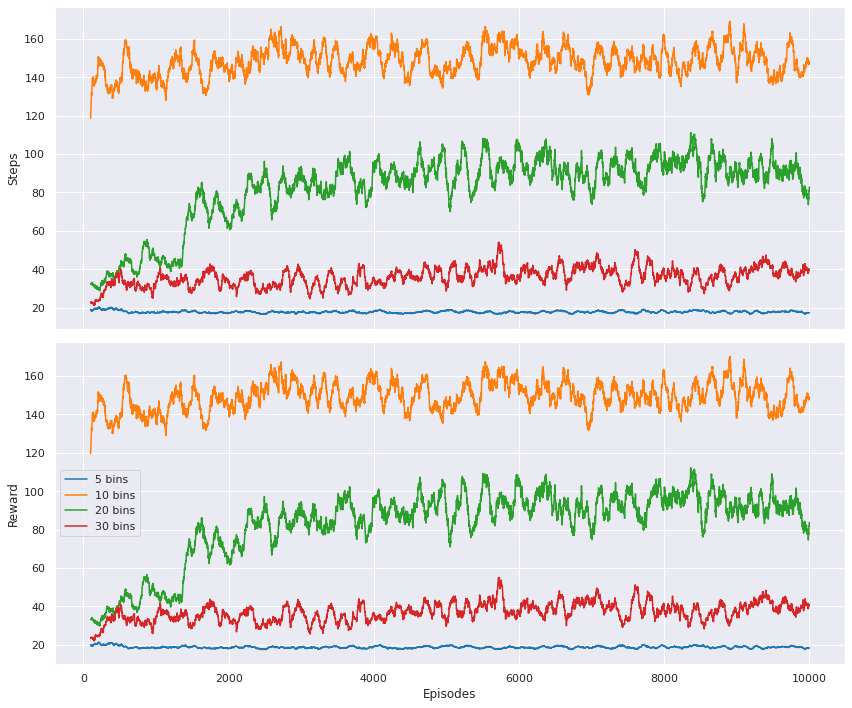

In [ ]:
plot_q_learning_stats(agents_with_different_bins, figsize=(12,10), smoothing_window=100)

As expected, increasing the number of bins past a threshold largely increases the granularity of the observations, so that the difference between states is very small (e.g.: moving half a milimiter), not necessarily making the agent perform better. Using 10 bins give a good overall performance. It is also worth noting that increasing the number of bins largely increase the memory consumption. To give a comparison, the number of bins, states stored in the Q table, and the memory comsumption of the object after construction are shown in the table below. The peak memory consumption and the memory increment were generated by the [%memit](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb) magic function.

| Number of Bins | States in the Q Table | Peak Memory Consumption | Memory Increment |
| :-- | :-- | :-- | :-- |
| 5 | 625 | 157.38 MiB | 0.13 MiB |
| 10 | 10,000 | 158.29 MiB | 0.73 MiB |
| 20 | 160,000 | 170.53 MiB | 12.23 MiB |
| 30 | 810,000 | 226.30 MiB | 55.77 MiB |

### Testing Different $N0$ Values

In [ ]:
agents_with_different_N0 = []
n_bins = 10

In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=0.1, name='N0 0.1')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_N0.append(agent)

Number of possible states: 10,000

Episode 250 finished after 12 steps with total reward 12.000
Avg for the last 100 episodes: reward = 49.390, number of steps: 48.390

Episode 500 finished after 19 steps with total reward 19.000
Avg for the last 100 episodes: reward = 59.450, number of steps: 58.450

Episode 750 finished after 125 steps with total reward 125.000
Avg for the last 100 episodes: reward = 61.150, number of steps: 60.150

Episode 1000 finished after 23 steps with total reward 23.000
Avg for the last 100 episodes: reward = 60.630, number of steps: 59.630


In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=0.5, name='N0 0.5')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_N0.append(agent)

Number of possible states: 10,000

Episode 250 finished after 31 steps with total reward 31.000
Avg for the last 100 episodes: reward = 136.890, number of steps: 135.890

Episode 500 finished after 120 steps with total reward 120.000
Avg for the last 100 episodes: reward = 106.840, number of steps: 105.840

Episode 750 finished after 107 steps with total reward 107.000
Avg for the last 100 episodes: reward = 110.140, number of steps: 109.140

Episode 1000 finished after 130 steps with total reward 130.000
Avg for the last 100 episodes: reward = 117.610, number of steps: 116.610


In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=1, name='N0 1')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_N0.append(agent)

Number of possible states: 10,000

Episode 250 finished after 181 steps with total reward 181.000
Avg for the last 100 episodes: reward = 139.960, number of steps: 138.960

Episode 500 finished after 87 steps with total reward 87.000
Avg for the last 100 episodes: reward = 148.300, number of steps: 147.300

Episode 750 finished after 185 steps with total reward 185.000
Avg for the last 100 episodes: reward = 136.310, number of steps: 135.310

Episode 1000 finished after 22 steps with total reward 22.000
Avg for the last 100 episodes: reward = 137.920, number of steps: 136.920


In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=10, name='N0 10')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_N0.append(agent)

Number of possible states: 10,000

Episode 250 finished after 163 steps with total reward 163.000
Avg for the last 100 episodes: reward = 154.270, number of steps: 153.270

Episode 500 finished after 169 steps with total reward 169.000
Avg for the last 100 episodes: reward = 161.920, number of steps: 160.920

Episode 750 finished after 13 steps with total reward 13.000
Avg for the last 100 episodes: reward = 165.020, number of steps: 164.020

Episode 1000 finished after 112 steps with total reward 112.000
Avg for the last 100 episodes: reward = 166.200, number of steps: 165.200


In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=100, name='N0 100')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_N0.append(agent)

Number of possible states: 10,000

Episode 250 finished after 52 steps with total reward 52.000
Avg for the last 100 episodes: reward = 56.350, number of steps: 55.350

Episode 500 finished after 123 steps with total reward 123.000
Avg for the last 100 episodes: reward = 80.810, number of steps: 79.810

Episode 750 finished after 210 steps with total reward 210.000
Avg for the last 100 episodes: reward = 90.440, number of steps: 89.440

Episode 1000 finished after 101 steps with total reward 101.000
Avg for the last 100 episodes: reward = 114.160, number of steps: 113.160


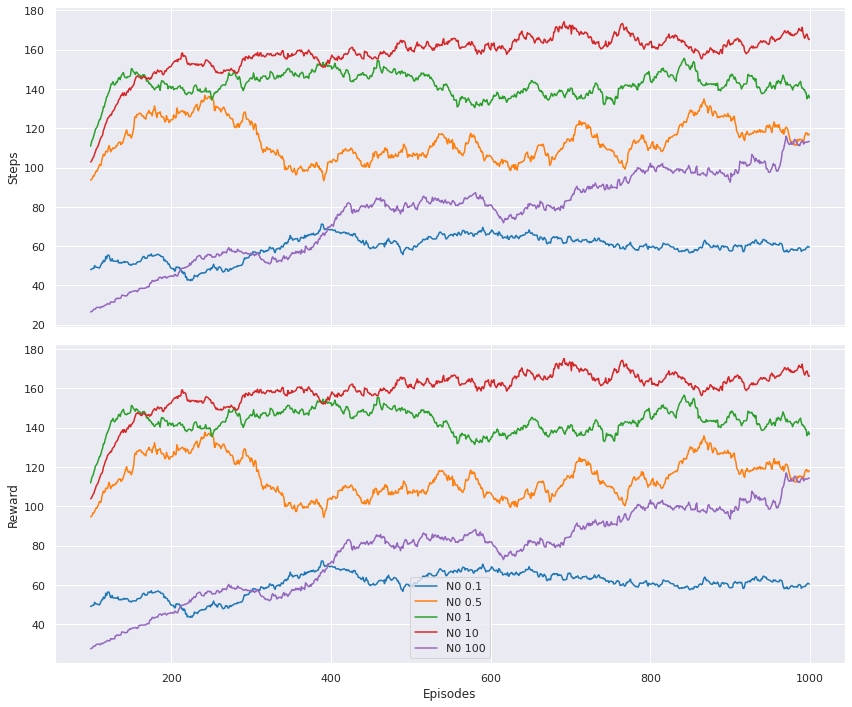

In [ ]:
plot_q_learning_stats(agents_with_different_N0, figsize=(12,10), smoothing_window=100)

Intuitivelly, the value of $N0$ that achieves the highest number of steps is 10, since it allows the agent to do a better exploration of possible actions. The value of 10 allows the agent to only greedy select the next action with higher probability after it visited the state around 10 times (as shown in the final discussion), while lower values of $N0$ prioritize much more the greedy selection.

### Testing Different $\gamma$ Values

In [ ]:
agents_with_different_gammas = []
N0 = 10

In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=0.1, name='gamma 0.1')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_gammas.append(agent)

Number of possible states: 10,000

Episode 250 finished after 128 steps with total reward 128.000
Avg for the last 100 episodes: reward = 133.410, number of steps: 132.410

Episode 500 finished after 34 steps with total reward 34.000
Avg for the last 100 episodes: reward = 160.310, number of steps: 159.310

Episode 750 finished after 257 steps with total reward 257.000
Avg for the last 100 episodes: reward = 143.950, number of steps: 142.950

Episode 1000 finished after 43 steps with total reward 43.000
Avg for the last 100 episodes: reward = 145.250, number of steps: 144.250


In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=0.5, name='gamma 0.5')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_gammas.append(agent)

Number of possible states: 10,000

Episode 250 finished after 50 steps with total reward 50.000
Avg for the last 100 episodes: reward = 32.500, number of steps: 31.500

Episode 500 finished after 72 steps with total reward 72.000
Avg for the last 100 episodes: reward = 33.920, number of steps: 32.920

Episode 750 finished after 15 steps with total reward 15.000
Avg for the last 100 episodes: reward = 39.700, number of steps: 38.700

Episode 1000 finished after 37 steps with total reward 37.000
Avg for the last 100 episodes: reward = 36.990, number of steps: 35.990


In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=0.9, name='gamma 0.9')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_gammas.append(agent)

Number of possible states: 10,000

Episode 250 finished after 175 steps with total reward 175.000
Avg for the last 100 episodes: reward = 151.580, number of steps: 150.580

Episode 500 finished after 185 steps with total reward 185.000
Avg for the last 100 episodes: reward = 148.790, number of steps: 147.790

Episode 750 finished after 187 steps with total reward 187.000
Avg for the last 100 episodes: reward = 164.860, number of steps: 163.860

Episode 1000 finished after 232 steps with total reward 232.000
Avg for the last 100 episodes: reward = 159.080, number of steps: 158.080


In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=0.999, name='gamma 0.999')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_gammas.append(agent)

Number of possible states: 10,000

Episode 250 finished after 10 steps with total reward 10.000
Avg for the last 100 episodes: reward = 21.000, number of steps: 20.000

Episode 500 finished after 11 steps with total reward 11.000
Avg for the last 100 episodes: reward = 22.610, number of steps: 21.610

Episode 750 finished after 13 steps with total reward 13.000
Avg for the last 100 episodes: reward = 21.440, number of steps: 20.440

Episode 1000 finished after 11 steps with total reward 11.000
Avg for the last 100 episodes: reward = 24.210, number of steps: 23.210


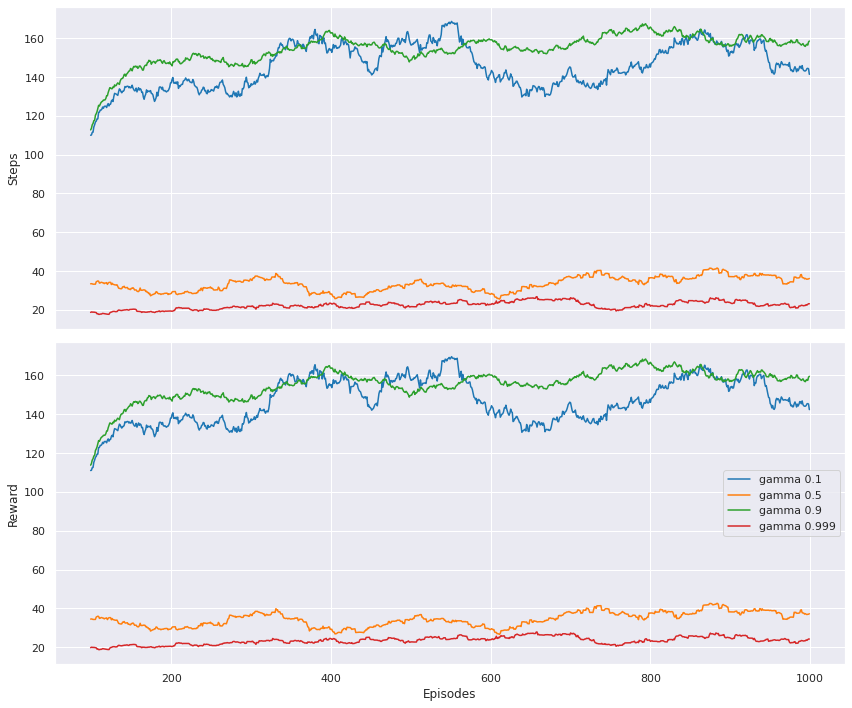

In [ ]:
plot_q_learning_stats(agents_with_different_gammas, figsize=(12,10), smoothing_window=100)

$\gamma$ is the discount factor used to weight the estimate of optimal future value. The higher the $\gamma$ the more importance is given to the next action to be taken during the update of the current state quality. As we could observe, this value is highly dependent on the initial distribution of the Q table, changing a few times between different execution. The most common value between the selected range is 0.9.

### Testing different additional rewards/penalties

Keeping the same base signature of all additional rewards functions: `def bonus(steps, observation)`

In [ ]:
agents_with_additional_rewards = []
gamma = 0.9

In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=None, name='No Additional Reward')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_additional_rewards.append(agent)

Number of possible states: 10,000

Episode 250 finished after 120 steps with total reward 120.000
Avg for the last 100 episodes: reward = 171.250, number of steps: 170.250

Episode 500 finished after 84 steps with total reward 84.000
Avg for the last 100 episodes: reward = 179.760, number of steps: 178.760

Episode 750 finished after 170 steps with total reward 170.000
Avg for the last 100 episodes: reward = 175.130, number of steps: 174.130

Episode 1000 finished after 97 steps with total reward 97.000
Avg for the last 100 episodes: reward = 168.580, number of steps: 167.580


In [ ]:
def step_bonus(steps, observation, checkpoint_steps=25):
  if steps > checkpoint_steps:
    # get extra reward every checkpoint_steps
    return steps // checkpoint_steps
  else:
    return 0


agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=step_bonus, name='Step Bonus')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_additional_rewards.append(agent)

Number of possible states: 10,000

Episode 250 finished after 53 steps with total reward 83.000
Avg for the last 100 episodes: reward = 53.200, number of steps: 30.070

Episode 500 finished after 45 steps with total reward 64.000
Avg for the last 100 episodes: reward = 102.110, number of steps: 38.370

Episode 750 finished after 36 steps with total reward 46.000
Avg for the last 100 episodes: reward = 202.530, number of steps: 55.180

Episode 1000 finished after 70 steps with total reward 134.000
Avg for the last 100 episodes: reward = 267.130, number of steps: 64.780


In [ ]:
def pole_angle_based_reward(steps, observation, max_angle=3):
  pole_angle = observation[2]
  angle = max_angle * 2 * math.pi / 360
  if pole_angle < -angle or pole_angle > angle:
    # penalize if angle is higher than max_angle
    return -200
  else:
    # give a bonus otherwise
    return 100


agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=pole_angle_based_reward,
                  name='Pole Angle Based Reward')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_additional_rewards.append(agent)

Number of possible states: 10,000

Episode 250 finished after 289 steps with total reward 26789.000
Avg for the last 100 episodes: reward = 11093.950, number of steps: 188.950

Episode 500 finished after 249 steps with total reward 19149.000
Avg for the last 100 episodes: reward = 20011.950, number of steps: 264.950

Episode 750 finished after 484 steps with total reward 39584.000
Avg for the last 100 episodes: reward = 21036.140, number of steps: 265.140

Episode 1000 finished after 400 steps with total reward 35600.000
Avg for the last 100 episodes: reward = 20966.000, number of steps: 264.000


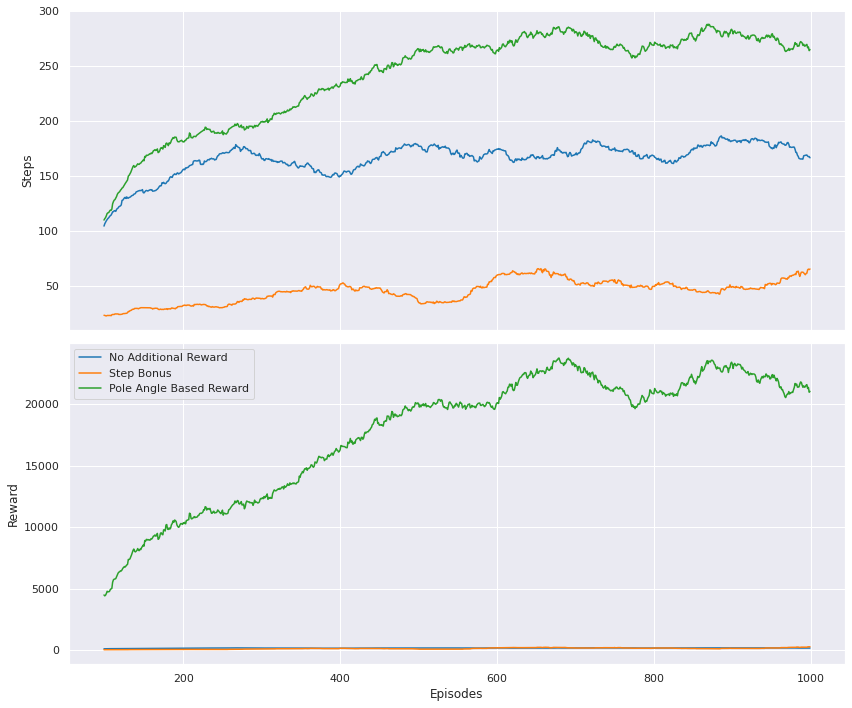

In [ ]:
plot_q_learning_stats(agents_with_additional_rewards, figsize=(12,10), smoothing_window=100)

Adding additional reward functions might improve the results, even more when it is problem specific. Here we tested three different configurations: no extra rewards, giving bonuses whenever a checkpoint is reached (specified number of steps), and using a pole angle based reward. This last reward penalizes the agent if the pole angle in respect to the vertical is higher than a given threshold (3 degrees). Since the problem involves the agent learn to balance the pole for a long number of steps and to balance the pole it must stay as closest as possible to the vertical, this additional reward gives the best result.

### Testing different finish bonuses

Keeping the same base signature of all finish bonuses functions: `def bonus(steps)`

In [ ]:
agents_with_different_bonuses = []
additional_reward_fn = None

In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=None, name='No Bonuses')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_bonuses.append(agent)

Number of possible states: 10,000

Episode 250 finished after 175 steps with total reward 175.000
Avg for the last 100 episodes: reward = 110.590, number of steps: 109.590

Episode 500 finished after 42 steps with total reward 42.000
Avg for the last 100 episodes: reward = 91.890, number of steps: 90.890

Episode 750 finished after 123 steps with total reward 123.000
Avg for the last 100 episodes: reward = 116.290, number of steps: 115.290

Episode 1000 finished after 241 steps with total reward 241.000
Avg for the last 100 episodes: reward = 98.300, number of steps: 97.300


In [ ]:
def high_penalty(steps, max_steps=500):
  if steps < max_steps - 1:
    return -max_steps
  else:
    return 0


agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=high_penalty, name='High Penalty')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_bonuses.append(agent)

Number of possible states: 10,000

Episode 250 finished after 216 steps with total reward -284.000
Avg for the last 100 episodes: reward = -308.190, number of steps: 175.810

Episode 500 finished after 167 steps with total reward -333.000
Avg for the last 100 episodes: reward = -306.460, number of steps: 187.540

Episode 750 finished after 173 steps with total reward -327.000
Avg for the last 100 episodes: reward = -288.340, number of steps: 195.660

Episode 1000 finished after 257 steps with total reward -243.000
Avg for the last 100 episodes: reward = -279.130, number of steps: 204.870


In [ ]:
def finish_bonus(steps, checkpoint_steps=25):
  if steps > checkpoint_steps:
    # get extra reward every checkpoint_steps
    return steps // checkpoint_steps
  else:
    # get penalty for not getting to first checkpoint_steps
    return steps - checkpoint_steps


agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus, name='Penalty_and_Bonus')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_bonuses.append(agent)

Number of possible states: 10,000

Episode 250 finished after 55 steps with total reward 57.000
Avg for the last 100 episodes: reward = 101.400, number of steps: 97.350

Episode 500 finished after 63 steps with total reward 65.000
Avg for the last 100 episodes: reward = 126.320, number of steps: 120.990

Episode 750 finished after 45 steps with total reward 46.000
Avg for the last 100 episodes: reward = 124.720, number of steps: 119.410

Episode 1000 finished after 132 steps with total reward 137.000
Avg for the last 100 episodes: reward = 119.220, number of steps: 114.150


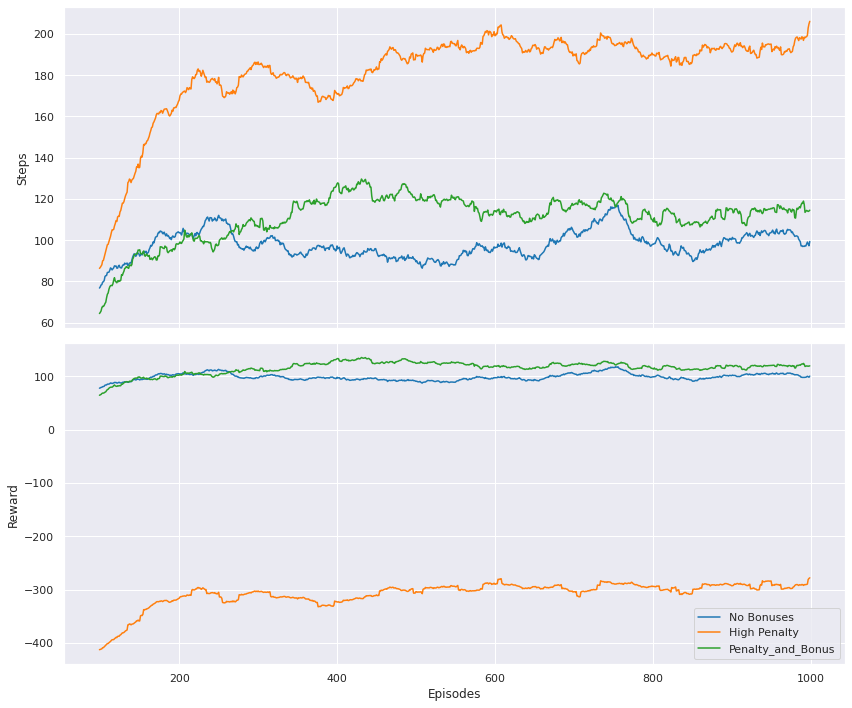

In [ ]:
plot_q_learning_stats(agents_with_different_bonuses, figsize=(12,10), smoothing_window=100)

Adding bonuses/penalties when an episode ends might also improve the learning of the agent, as demonstrated in the graph above. Adding a high penalty for not achieving the highest possible number of steps balancing the pole largely improved the agent learning, even though the reward values stayed low.

### Testing Different Observation Slices

In [ ]:
agents_with_different_observations = []
finish_bonus_fn = None
additional_reward_fn = None

In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=[0,1,2,3], name='All Variables')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 10,000

Episode 250 finished after 79 steps with total reward 79.000
Avg for the last 100 episodes: reward = 123.030, number of steps: 122.030

Episode 500 finished after 107 steps with total reward 107.000
Avg for the last 100 episodes: reward = 146.290, number of steps: 145.290

Episode 750 finished after 225 steps with total reward 225.000
Avg for the last 100 episodes: reward = 145.080, number of steps: 144.080

Episode 1000 finished after 136 steps with total reward 136.000
Avg for the last 100 episodes: reward = 163.340, number of steps: 162.340


In [ ]:
observations_to_use = [1, 2, 3]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Ignoring {[o for o in range(4) if o not in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 1,000

Episode 250 finished after 26 steps with total reward 26.000
Avg for the last 100 episodes: reward = 23.980, number of steps: 22.980

Episode 500 finished after 15 steps with total reward 15.000
Avg for the last 100 episodes: reward = 27.780, number of steps: 26.780

Episode 750 finished after 20 steps with total reward 20.000
Avg for the last 100 episodes: reward = 29.890, number of steps: 28.890

Episode 1000 finished after 21 steps with total reward 21.000
Avg for the last 100 episodes: reward = 30.550, number of steps: 29.550


In [ ]:
observations_to_use = [0, 2, 3]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Ignoring {[o for o in range(4) if o not in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 1,000

Episode 250 finished after 141 steps with total reward 141.000
Avg for the last 100 episodes: reward = 151.770, number of steps: 150.770

Episode 500 finished after 101 steps with total reward 101.000
Avg for the last 100 episodes: reward = 148.950, number of steps: 147.950

Episode 750 finished after 109 steps with total reward 109.000
Avg for the last 100 episodes: reward = 162.120, number of steps: 161.120

Episode 1000 finished after 162 steps with total reward 162.000
Avg for the last 100 episodes: reward = 153.030, number of steps: 152.030


In [ ]:
observations_to_use = [0, 1, 3]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Ignoring {[o for o in range(4) if o not in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 1,000

Episode 250 finished after 134 steps with total reward 134.000
Avg for the last 100 episodes: reward = 71.890, number of steps: 70.890

Episode 500 finished after 31 steps with total reward 31.000
Avg for the last 100 episodes: reward = 79.780, number of steps: 78.780

Episode 750 finished after 43 steps with total reward 43.000
Avg for the last 100 episodes: reward = 84.200, number of steps: 83.200

Episode 1000 finished after 147 steps with total reward 147.000
Avg for the last 100 episodes: reward = 76.130, number of steps: 75.130


In [ ]:
observations_to_use = [0, 1, 2]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Ignoring {[o for o in range(4) if o not in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 1,000

Episode 250 finished after 105 steps with total reward 105.000
Avg for the last 100 episodes: reward = 37.320, number of steps: 36.320

Episode 500 finished after 152 steps with total reward 152.000
Avg for the last 100 episodes: reward = 43.980, number of steps: 42.980

Episode 750 finished after 11 steps with total reward 11.000
Avg for the last 100 episodes: reward = 55.040, number of steps: 54.040

Episode 1000 finished after 52 steps with total reward 52.000
Avg for the last 100 episodes: reward = 46.460, number of steps: 45.460


In [ ]:
observations_to_use = [0, 1]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Considering {[o for o in range(4) if o in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 100

Episode 250 finished after 47 steps with total reward 47.000
Avg for the last 100 episodes: reward = 39.600, number of steps: 38.600

Episode 500 finished after 22 steps with total reward 22.000
Avg for the last 100 episodes: reward = 41.950, number of steps: 40.950

Episode 750 finished after 26 steps with total reward 26.000
Avg for the last 100 episodes: reward = 41.600, number of steps: 40.600

Episode 1000 finished after 57 steps with total reward 57.000
Avg for the last 100 episodes: reward = 38.130, number of steps: 37.130


In [ ]:
observations_to_use = [0, 2]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Considering {[o for o in range(4) if o in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 100

Episode 250 finished after 13 steps with total reward 13.000
Avg for the last 100 episodes: reward = 22.260, number of steps: 21.260

Episode 500 finished after 19 steps with total reward 19.000
Avg for the last 100 episodes: reward = 22.140, number of steps: 21.140

Episode 750 finished after 15 steps with total reward 15.000
Avg for the last 100 episodes: reward = 22.350, number of steps: 21.350

Episode 1000 finished after 21 steps with total reward 21.000
Avg for the last 100 episodes: reward = 22.530, number of steps: 21.530


In [ ]:
observations_to_use = [0, 3]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Considering {[o for o in range(4) if o in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 100

Episode 250 finished after 149 steps with total reward 149.000
Avg for the last 100 episodes: reward = 166.220, number of steps: 165.220

Episode 500 finished after 120 steps with total reward 120.000
Avg for the last 100 episodes: reward = 151.940, number of steps: 150.940

Episode 750 finished after 156 steps with total reward 156.000
Avg for the last 100 episodes: reward = 146.280, number of steps: 145.280

Episode 1000 finished after 127 steps with total reward 127.000
Avg for the last 100 episodes: reward = 154.930, number of steps: 153.930


In [ ]:
observations_to_use = [1, 2]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Considering {[o for o in range(4) if o in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 100

Episode 250 finished after 79 steps with total reward 79.000
Avg for the last 100 episodes: reward = 77.420, number of steps: 76.420

Episode 500 finished after 101 steps with total reward 101.000
Avg for the last 100 episodes: reward = 73.300, number of steps: 72.300

Episode 750 finished after 84 steps with total reward 84.000
Avg for the last 100 episodes: reward = 70.440, number of steps: 69.440

Episode 1000 finished after 64 steps with total reward 64.000
Avg for the last 100 episodes: reward = 79.220, number of steps: 78.220


In [ ]:
observations_to_use = [1, 3]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Considering {[o for o in range(4) if o in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 100

Episode 250 finished after 226 steps with total reward 226.000
Avg for the last 100 episodes: reward = 189.710, number of steps: 188.710

Episode 500 finished after 167 steps with total reward 167.000
Avg for the last 100 episodes: reward = 198.970, number of steps: 197.970

Episode 750 finished after 170 steps with total reward 170.000
Avg for the last 100 episodes: reward = 195.040, number of steps: 194.040

Episode 1000 finished after 211 steps with total reward 211.000
Avg for the last 100 episodes: reward = 198.720, number of steps: 197.720


In [ ]:
observations_to_use = [2, 3]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Considering {[o for o in range(4) if o in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 100

Episode 250 finished after 176 steps with total reward 176.000
Avg for the last 100 episodes: reward = 182.910, number of steps: 181.910

Episode 500 finished after 171 steps with total reward 171.000
Avg for the last 100 episodes: reward = 183.510, number of steps: 182.510

Episode 750 finished after 213 steps with total reward 213.000
Avg for the last 100 episodes: reward = 186.110, number of steps: 185.110

Episode 1000 finished after 210 steps with total reward 210.000
Avg for the last 100 episodes: reward = 182.210, number of steps: 181.210


In [ ]:
observations_to_use = [0]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Considering {[o for o in range(4) if o in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 10

Episode 250 finished after 9 steps with total reward 9.000
Avg for the last 100 episodes: reward = 9.630, number of steps: 8.630

Episode 500 finished after 8 steps with total reward 8.000
Avg for the last 100 episodes: reward = 9.430, number of steps: 8.430

Episode 750 finished after 9 steps with total reward 9.000
Avg for the last 100 episodes: reward = 9.300, number of steps: 8.300

Episode 1000 finished after 9 steps with total reward 9.000
Avg for the last 100 episodes: reward = 9.340, number of steps: 8.340


In [ ]:
observations_to_use = [1]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Considering {[o for o in range(4) if o in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 10

Episode 250 finished after 57 steps with total reward 57.000
Avg for the last 100 episodes: reward = 39.860, number of steps: 38.860

Episode 500 finished after 55 steps with total reward 55.000
Avg for the last 100 episodes: reward = 41.440, number of steps: 40.440

Episode 750 finished after 47 steps with total reward 47.000
Avg for the last 100 episodes: reward = 39.930, number of steps: 38.930

Episode 1000 finished after 21 steps with total reward 21.000
Avg for the last 100 episodes: reward = 37.780, number of steps: 36.780


In [ ]:
observations_to_use = [2]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Considering {[o for o in range(4) if o in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 10

Episode 250 finished after 12 steps with total reward 12.000
Avg for the last 100 episodes: reward = 19.900, number of steps: 18.900

Episode 500 finished after 21 steps with total reward 21.000
Avg for the last 100 episodes: reward = 19.230, number of steps: 18.230

Episode 750 finished after 15 steps with total reward 15.000
Avg for the last 100 episodes: reward = 20.850, number of steps: 19.850

Episode 1000 finished after 24 steps with total reward 24.000
Avg for the last 100 episodes: reward = 19.990, number of steps: 18.990


In [ ]:
observations_to_use = [3]
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use,
                  name=f'Considering {[o for o in range(4) if o in observations_to_use]}')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_observations.append(agent)

Number of possible states: 10

Episode 250 finished after 16 steps with total reward 16.000
Avg for the last 100 episodes: reward = 16.280, number of steps: 15.280

Episode 500 finished after 16 steps with total reward 16.000
Avg for the last 100 episodes: reward = 15.860, number of steps: 14.860

Episode 750 finished after 12 steps with total reward 12.000
Avg for the last 100 episodes: reward = 16.000, number of steps: 15.000

Episode 1000 finished after 13 steps with total reward 13.000
Avg for the last 100 episodes: reward = 15.860, number of steps: 14.860


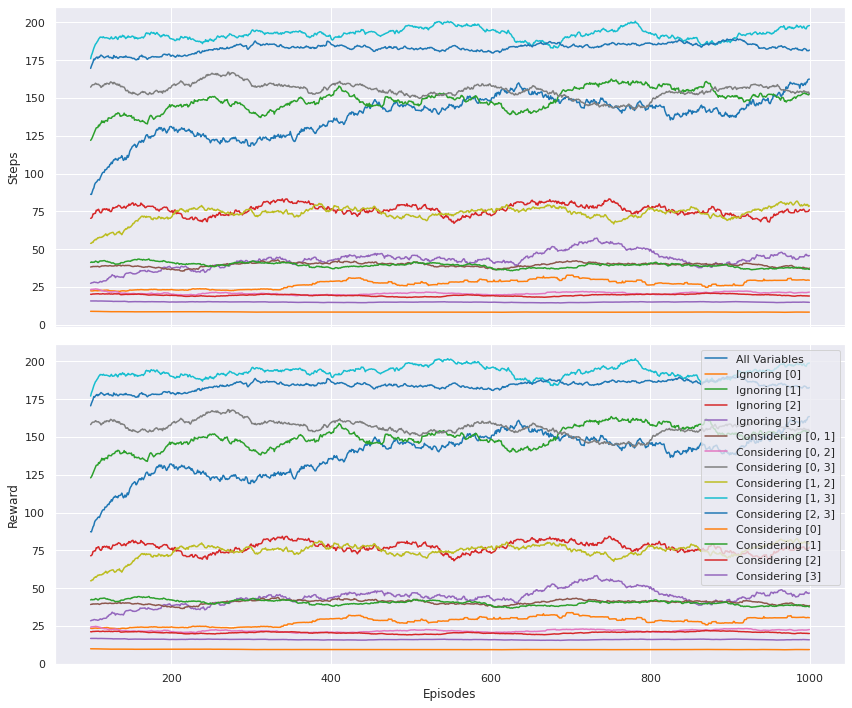

In [ ]:
plot_q_learning_stats(agents_with_different_observations, figsize=(12,10), smoothing_window=100)

Contrary to our expectations, using the whole observation spectre does not give the best overall result. By analyzing the results we can clearly identify that variables 1 and 3 from the observation (cart velocity and pole angular velocity) are the most relevant ones, since all the top solutions involve these variables, being the one that uses only these two the one with the best results.

### Testing Different Q Initialization Ranges

In [ ]:
agents_with_different_q_init_boundaries = []
observations_to_use = [1, 3]

In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use, low_q=-1, high_q=1,
                  name='Q -1 to 1')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_q_init_boundaries.append(agent)

Number of possible states: 100

Episode 250 finished after 26 steps with total reward 26.000
Avg for the last 100 episodes: reward = 93.450, number of steps: 92.450

Episode 500 finished after 35 steps with total reward 35.000
Avg for the last 100 episodes: reward = 98.110, number of steps: 97.110

Episode 750 finished after 82 steps with total reward 82.000
Avg for the last 100 episodes: reward = 94.190, number of steps: 93.190

Episode 1000 finished after 33 steps with total reward 33.000
Avg for the last 100 episodes: reward = 100.400, number of steps: 99.400


In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use, low_q=0, high_q=1,
                  name='Q 0 to 1')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_q_init_boundaries.append(agent)

Number of possible states: 100

Episode 250 finished after 81 steps with total reward 81.000
Avg for the last 100 episodes: reward = 163.750, number of steps: 162.750

Episode 500 finished after 156 steps with total reward 156.000
Avg for the last 100 episodes: reward = 165.810, number of steps: 164.810

Episode 750 finished after 137 steps with total reward 137.000
Avg for the last 100 episodes: reward = 159.860, number of steps: 158.860

Episode 1000 finished after 145 steps with total reward 145.000
Avg for the last 100 episodes: reward = 160.650, number of steps: 159.650


In [ ]:
agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps, max_boundary_values=max_boundary_values,
                  n_bins=n_bins, N0=N0, gamma=gamma, additional_reward_fn=additional_reward_fn,
                  finish_bonus_fn=finish_bonus_fn, observations_to_use=observations_to_use, low_q=0, high_q=0,
                  name='Q 0')
run_q_agent(agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps, info_for_last_eps=info_for_last_eps)
agents_with_different_q_init_boundaries.append(agent)

Number of possible states: 100

Episode 250 finished after 27 steps with total reward 27.000
Avg for the last 100 episodes: reward = 44.490, number of steps: 43.490

Episode 500 finished after 22 steps with total reward 22.000
Avg for the last 100 episodes: reward = 42.940, number of steps: 41.940

Episode 750 finished after 30 steps with total reward 30.000
Avg for the last 100 episodes: reward = 38.830, number of steps: 37.830

Episode 1000 finished after 38 steps with total reward 38.000
Avg for the last 100 episodes: reward = 41.000, number of steps: 40.000


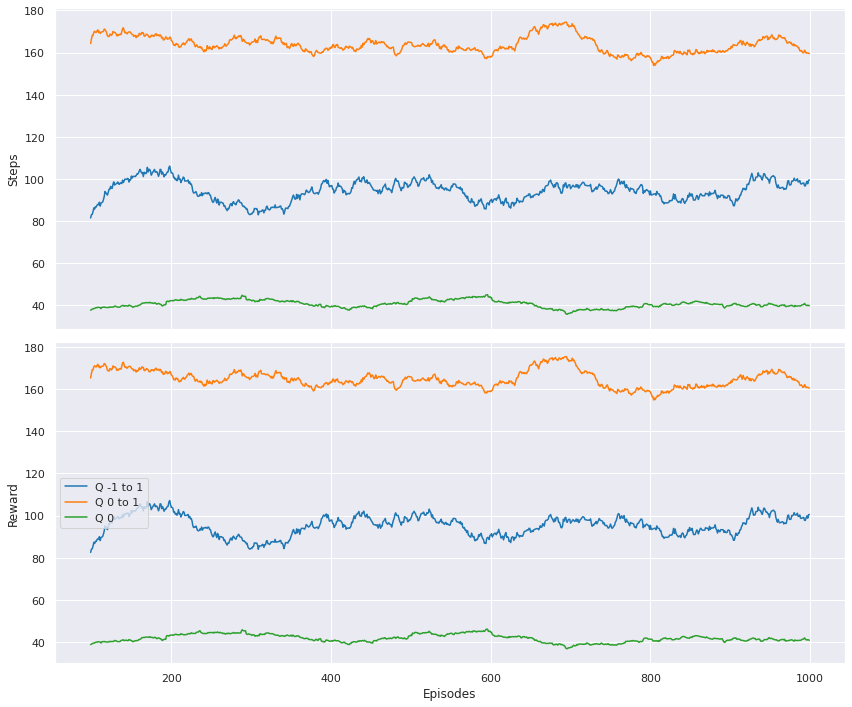

In [ ]:
plot_q_learning_stats(agents_with_different_q_init_boundaries, figsize=(12,10), smoothing_window=100)

It seems that initializing the Q table with negative values disturbs the training process. This is probably related to the selected values for other variables used during the Q table update, like $\gamma$ and $\alpha$. Also using the same initial value (zero in this case) for the whole tabe gives even worse results.

### Best Solution Found

After the first best parameters is found, we set its value as the best result for the next parameter search, and so on. The best combination of parameters found was:

| Variable | Best value |
| :-- | :-- |
| Number of Bins | 10 |
| N0 | 10 |
| $\gamma$ | 0.9 |
| Additional Reward | Pole Angle Based Reward |
| Finishing Reward | High Penalty |
| Observation Slices | [1, 3] (cart velocity and pole angular velocity) |
| Q-table Initialization | 0 to 1 |

To do a more fair comparison with other methods, for our best solution we will remove the pole angle based reward function. Since the difference between using the best observation slices and all observations is not that large, we will use the whole observation.

Number of possible states: 10,000

Episode 250 finished after 83 steps with total reward -417.000
Avg for the last 100 episodes: reward = -321.140, number of steps: 177.860

Episode 500 finished after 167 steps with total reward -333.000
Avg for the last 100 episodes: reward = -295.430, number of steps: 203.570

Episode 750 finished after 206 steps with total reward -294.000
Avg for the last 100 episodes: reward = -289.350, number of steps: 209.650

Episode 1000 finished after 186 steps with total reward -314.000
Avg for the last 100 episodes: reward = -290.770, number of steps: 208.230


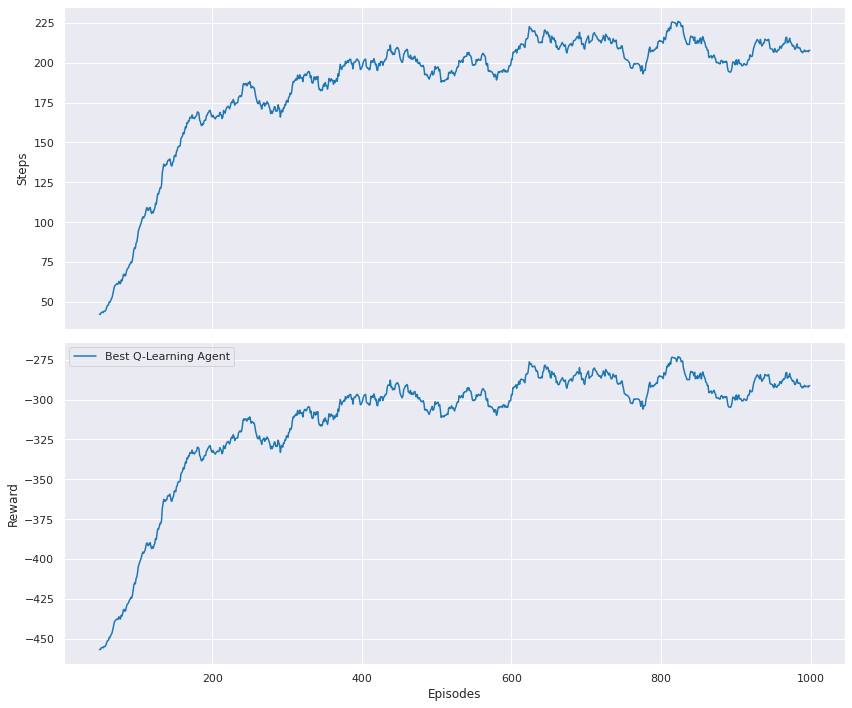

In [ ]:
def pole_angle_based_reward(steps, observation, max_angle=3):
  pole_angle = observation[2]
  angle = max_angle * 2 * math.pi / 360
  if pole_angle < -angle or pole_angle > angle:
    return -200
  else:
    return 100


def high_penalty(steps, max_steps=500):
  if steps < max_steps - 1:
    return -max_steps
  else:
    return 0


# additional_reward_fn = pole_angle_based_reward
additional_reward_fn = None
finish_bonus_fn = high_penalty
gamma = 0.9
high_q = 1
low_q = 0
max_boundary_values = [(-2.5, 2.5), (-3.2, 3.2), (-0.3, 0.3), (-3.7, 3.7)]
n_bins = 10
# observations_to_use = [1, 3]
observations_to_use = [0, 1, 2, 3]
N0 = 10


best_q_learning_agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps,
                                  max_boundary_values=max_boundary_values, n_bins=n_bins, N0=N0, gamma=gamma,
                                  additional_reward_fn=additional_reward_fn, finish_bonus_fn=finish_bonus_fn,
                                  low_q=low_q, high_q=high_q, observations_to_use=observations_to_use,
                                  name='Best Q-Learning Agent')
run_q_agent(best_q_learning_agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps,
            info_for_last_eps=info_for_last_eps)

plot_q_learning_stats([best_q_learning_agent], figsize=(12,10), smoothing_window=50)

#### Video Result

In [ ]:
# Show video of optimal parameters
env = wrap_env(gym.make('CartPole-v1'))
display = Display(visible=0, size=(1400, 900))
display.start()

observation = env.reset()

for _ in range(1_000):
    indices = tuple([np.digitize(o, b) for o, b in zip(observation, best_q_learning_agent.bins_limits)])
    action = np.argmax(best_q_learning_agent.q_table[indices])
    observation, reward, done, info = env.step(action)
    env.render()
    if done:
        break

env.close()
show_video()

Displaying video/openaigym.video.1.5696.video000000.mp4


### Advantages
- it is an off-policy method, which allows our agent to evaluate one policy while following another; what means, it can learn from observing other agent, including human agents or older learned policies;
- converges to the optimal policy, independent of the policy being followed, as long as all actions are repeatedly sampled in all states and the action-values are represented discretely.

### Disadvantages
- Slow to converge, needing to run a lot of episodes;
- As an off-policy method, it does not always converge.

<a name="sarsa-experiments"></a>

## [SARSA(λ)](http://incompleteideas.net/book/first/ebook/node64.html)
---

In this first experiment, we performed a grid search to recognize the best parameters for our task. The optimal parameters found during the exploration were:
**Gamma**: 1,
**Lambda**: 0.8,
**N0**: 10,
**Reward mode**: Based on pole angle,
**Alpha**: 0.2.

For all tests we keep the parameters the same except the one we are testing.
The reward is equal to 1 for all steps taken in the plots. However, to compute the algorithm's internal values, the rewards have been assigned accordingly to the function chosen. With that in mind, the maximum reward value in an episode is equivalent to the time-step limit size, in our case 500. 

In [ ]:
gammas = np.arange(0, 1.1, 0.5)
lambdas = np.arange(0, 1.2, 0.2)
N0s = [0.1, 1, 10, 100]
reward_modes = [0, 1, 2]
alphas = [0, 0.001, 0.01, 0.2, 1]

param_to_test = [gammas, lambdas, N0s, reward_modes, alphas]
parameters_list = ['gamma', 'lamb', 'N0', 'reward_fun', 'alpha']

n_episode = 1000

In [ ]:
parameters_search = {}

for parameters, parameter_name in zip(param_to_test, parameters_list):
  results = []
  for parameter in parameters:
    # Just change the value passed
    p = {parameter_name:parameter}
    s = SarsaLambda(env=env, n_episode=n_episode, **p)

    results.append(s.exec_sarsa_lambda())
        
  parameters_search[parameter_name] = results       

In [ ]:
plots_labels = ['$γ = {:.1f}$', 
                '$λ = {:.1f}$', 
                '$N0 = {:.1f}$', 
                '$Reward = {:.1f}$',
                '$α = {:.3f}$']

#####**Gamma analysis**

In the first experiment, we investigate how the discount factor $\gamma$ influences the model performance. $\gamma$ can assume any value from 0 to 1. It refers to the importance assigned for future experiences: lower values mean the model cares only about immediate returns otherwise considers future rewards. The first graph shows the results obtained for $\gamma$ equal to 0, 0.5, and 1. The best outcome reached was using $\gamma = 1$, which makes sense given the observation attributes accumulate small changes over time. This information might help the algorithm understand whether it will improve or finish precociously.

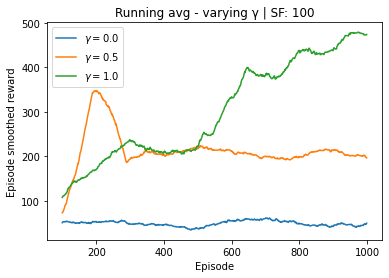

In [ ]:
plot_all_sarsa(stop_where=parameters_list[0], stats=parameters_search, feature_label=plots_labels, feature_values=param_to_test)

#####**Lambda analysis**


Next, we analyze the impact of varying $\lambda$ from 0 to 1 in increments of 0.2. The eligibility traces uses the lambda value to weight information from the past. In other words, the way we update old states. It means that lower values of lambda dismiss the past. We have found that intermediate values 0.8 to 0.4 confers better results. The plots show that it is better not to propagate the past error (using lower values for $\lambda$) than tracing it back to all history ($\lambda$ equal to one). It happened because, as we keep $\lambda$ fixed, the eligibility matrix is pondered by $\gamma$, set in 1 in the baseline. In short, by making lambda 1 in the baseline configurations, the algorithm only regards the future. In other words, it considers that all the states have the same importance, even if it is not more visited, as a consequence it dismisses the past scattering.

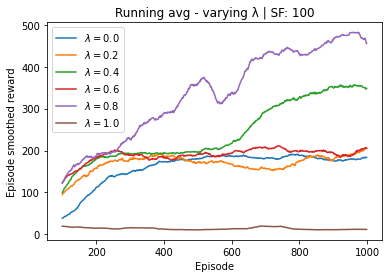

In [ ]:
plot_all_sarsa(stop_where=parameters_list[1], stats=parameters_search, feature_label=plots_labels, feature_values=param_to_test)

#####**N0 analysis**

We use the N0 constant to update the learning rate and the epsilon decay for policy improvement. In the graph, using a high value for N0, we can see that the algorithm is learning, given the number of steps taken is increasing over episodes, although the convergence is slow. In the same way, the $\epsilon$ decay requires more iterations to converge. For the other values, in the last episodes, the differences are subtle. N0 = 1 was stable over episodes,   but we decided for N0 = 10 once it completed the last episode with the highest reward.

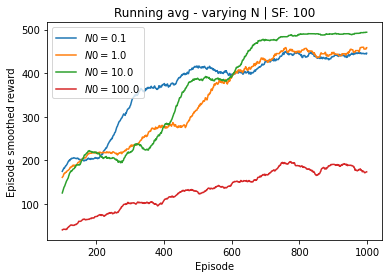

In [ ]:
plot_all_sarsa(stop_where=parameters_list[2], stats=parameters_search, feature_label=plots_labels, feature_values=param_to_test)

#####**Reward mode analysis**

Finally, we evaluate the reward function. We tried the three approaches described in the [reward explanation](#reward-functions) section. Neither the reward mode 0 nor the 1 penalize the algorithm based on the observation attributes. In the experiments, we combined reward mode 1 and 2 with method 0.  In view of that alone, the simplest one acts better, followed by the pole angle-based approach, which improves continually. Despite the checkpoint reward function obtain the worst average reward over steps, the graph shows a continuous increase in the learning process. Because of the policy improvement graph, the methods that do not consider the observation attributes tend to achieve smaller results. We hypothesize it happens since the discretization process is limited, and then, the more information we ponder to penalize the model, the better to find the optimal policy.

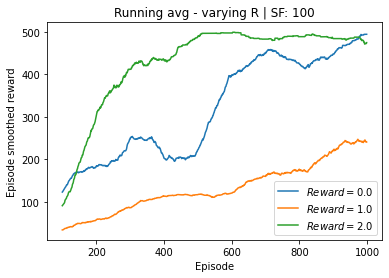

In [ ]:
plot_all_sarsa(stop_where=parameters_list[3], stats=parameters_search, feature_label=plots_labels, feature_values=param_to_test)

#####**Alpha analysis**

**Important**: In the graph, the blue line labeled as alpha zero refers to the adaptative process.

We also evaluate the impact of adjusting $\alpha$, counting the number of times the current state was visited or keeping it fixed. The adaptative learning rate relies on the number of visits to the current state. In this context, the first episodes have a higher learning rate, equal to one, which helps the model converge fast. The learning rate is inversely proportional to the number of visits in a state. With that in mind, it tends to improve in small steps. Using small values, even though the system tends to convergence, it does this slow. By making it equal to 0.2, we could achieve good results. 

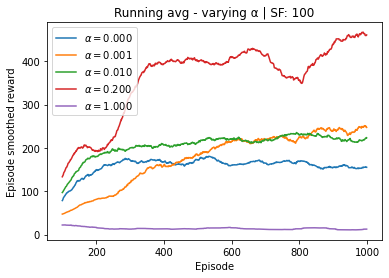

In [ ]:
plot_all_sarsa(stop_where=parameters_list[4], stats=parameters_search, feature_label=plots_labels, feature_values=param_to_test)

In [ ]:
# Try different conf. for discretization

bins = [5,10,20]
idx = [[0], [1], [2], [3], [0,1], [3,0], [3,1], [3,2], [0,1,2,3]]

param_to_test = [bins, idx]
parameters_list = ['n_bins', 'idx']

parameters_search = {}
for parameters, parameter_name in zip(param_to_test, parameters_list):
  results = []
  for parameter in parameters:
    # Just change the value passed
    p = {parameter_name:parameter}
    s = SarsaLambda(env=env, n_episode=n_episode, **p)

    results.append(s.exec_sarsa_lambda())
        
  parameters_search[parameter_name] = results 

In [ ]:
plots_labels = ['$Bins = {:.1f}$', 
                '$Obs. Att. = {}$']

#####**Bins analysis**

Similar to previous methods, we have investigated how the discretization process impacts the model execution. For this, we apply the same configuration setup. As previously mentioned, a higher number of bins can better represent the observation attributes, considering it discriminates individual properties more precisely. At the same time, the amount of states grows proportionally, which makes the model convergence slow. Describing the environment with only 5 bins makes the system noisy, given that a lot of relevant state information is lost. For our task, 10 bins were enough to discriminate the states satisfactorily. However, to increase the model precision, we need to train to model on more episodes and increase the number of bins used to describe the environment.

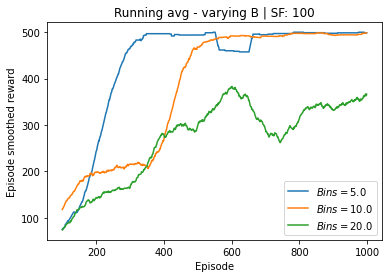

In [ ]:
plot_all_sarsa(stop_where=parameters_list[0], stats=parameters_search, feature_label=plots_labels, feature_values=param_to_test)

#####**Observation attributes analysis**

Curiously, the model achieved the maximum steps per episode when all the observation attributes, or the second and the third properties only were used (respectively, the pole angle and pole velocity). In the graph, we can see that the last configuration reaches the limit steps in the first 300 episodes and keep like this until the end. We are not sure about why it happens, but let's speculate a bit. We are using only ten bins to discretize the environment. Empirically, we know it is not enough to represent all the states precisely. Probably, these two features are the most discriminative for the task; especially considering the constrain in the discretization process. As we did not have control of the cart's velocity, the current state changes in such a way the car did not move along the line faster. In other words, the model learns to interleave ingenious left and right actions to make to the pole in the center. It is why in the video, we can see to cart almost stopped. 


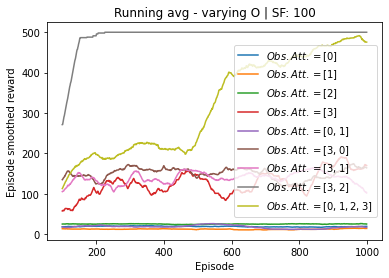

In [ ]:
plot_all_sarsa(stop_where=parameters_list[1], stats=parameters_search, feature_label=plots_labels, feature_values=param_to_test)

#####**Putting it all together**

In [ ]:
# Putting it all together.

n_episode = 1000
gamma = 1
alpha = 0.2
lamb = 0.8
N0 = 10
reward_fun = 2
n_bins = 10
idx = [2,3]

s = SarsaLambda(env=env, n_episode=n_episode, gamma=gamma, alpha=alpha, lamb=lamb, 
                N0=N0, reward_fun=reward_fun, n_bins=n_bins, idx=idx)

results = s.exec_sarsa_lambda()

In the figure below, we can see that the optimal value function has a higher value in the first states and suddenly decays to numbers closer to zero. The $Q$-table plot completely changes depending on the configuration setup. We can not say a lot about $Q$ values, except the highest value of states also represents the optimal policy. Because of that, we hypostatize that, in this approach, only a few amounts of states was visited, since the higher value of $Q$ means the state was more visited (or at least far from zero). In other words, the model has learned to only go to one state and return to the previous one, in a loop.

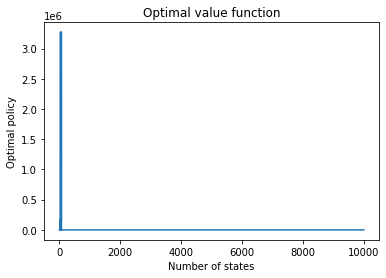

In [ ]:
Q = results[1]
statistics = results[0]
smooth_factor = 100
y = np.max(Q, axis=1)
y = y.tolist()

# Q plot
simple_plot(y, 'Number of states', 'Optimal policy', 'Optimal value function')

As we mentioned above, here the graph of the number of steps over episodes is almost the same as the reward running average, saving it has been smoothed to make it clear. Analyzing the graph, we can see that the model, in the first iterations, runs over 100 time-steps fulfilled, without success. Then reaches the limit amount of steps per iteration, varies a bit, and keep constant in 500 steps per episode until the end. Although it is a good aspect, it is also specially strange because it happened at the beginning of the learning process. Our hypothesis is that because, in this experiment, we had used only the pole attributes to represent all the environment. And also, the reward function relies on the pole angle and penalize the system accordingly to that, we reduce a lot the exploration limits, mainly for the other attributes neglected here.

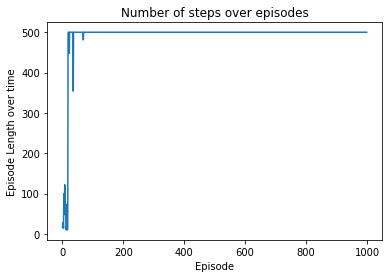

In [ ]:
# Episode size plot
simple_plot(statistics.episode_size, 'Episode', 'Episode Length over time', 'Number of steps over episodes')

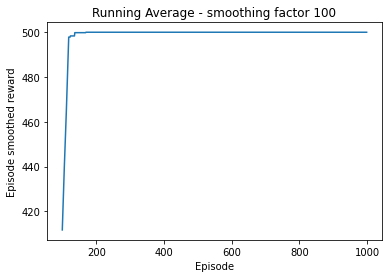

In [ ]:
# Moving average rewards plot
smooth_rew = pd.Series(statistics.episode_rewards).rolling(smooth_factor, min_periods=smooth_factor).mean()
simple_plot(smooth_rew, 'Episode', 'Episode smoothed reward', 'Running Average - smoothing factor {}'.format(smooth_factor))

To make sure the model is learning, despite the constraints, we evaluate the epsilon-greedy decay. In theory, we can say Sarsa converges if the GLIE sequence of polices tends to zeros. In the graph, we can see it occurs in the first iterations. Putting it in other words, the model achieves the best policy in less than 200 episodes, which is unbelievable. 

We can not say more about why it is happening using these settings, except it is strange. Probably the model is biased and did not have learned anything unless move left and right just to keep the pole upright as much as possible without get out of place. 

In view of that, we decided to retrain the model using all the observation attributes and keep the other parameters the same.


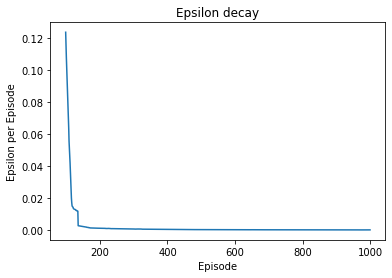

In [ ]:
# Epsilon plot
smooth_e = pd.Series(statistics.episode_epsilon).rolling(smooth_factor, min_periods=smooth_factor).mean()
simple_plot(smooth_e, 'Episode', 'Epsilon per Episode', 'Epsilon decay')

In the video below, we can see that the algorithm did not try to go faster or run over the line more than necessary to keep the pole in the safe boundary.

In [ ]:
# Show video optimal parameters

env = wrap_env(gym.make('CartPole-v1'))
display = Display(visible=0, size=(1400, 900))
display.start()

act_n = env.action_space.n
reward_avg = []
obs = env.reset()

for _ in range(10000):

    state = s.discretize_state(obs, idx=idx)

    action = np.argmax(s.Q[state])

    obs, reward, done, info = env.step(action)

    reward_avg.append(reward)
    
    env.render()
    if done:
        break
    # time.sleep(0.1)

env.close()
show_video()

Displaying video/openaigym.video.1.57.video000000.mp4


##### **Try it again using the entire observation attributes**

Now the optimal value function seems more similar to the other approaches presented early. Given that, we can conclude that the exploration and exploitation rates of the previous configuration setup are not reasonable. 

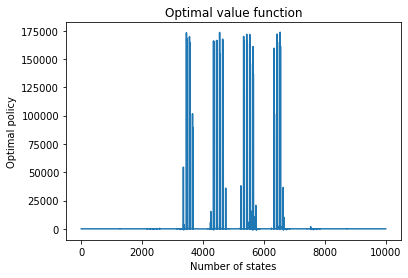

In [ ]:
n_episode = 1000
gamma = 1
alpha = 0.2
lamb = 0.8
N0 = 10
reward_fun = 2
n_bins = 10
idx = [0,1,2,3]

s = SarsaLambda(env=env, n_episode=n_episode, gamma=gamma, alpha=alpha, lamb=lamb, 
                N0=N0, reward_fun=reward_fun, n_bins=n_bins, idx=idx)

results = s.exec_sarsa_lambda()

Q = results[1]
statistics = results[0]
smooth_factor = 100
y = np.max(Q, axis=1)
y = y.tolist()

# Q plot
simple_plot(y, 'Number of states', 'Optimal policy', 'Optimal value function')

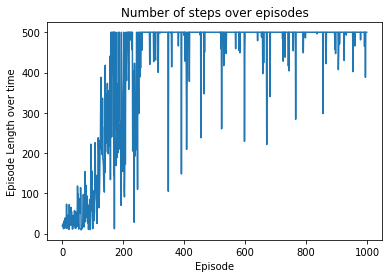

In [ ]:
# Episode size plot
simple_plot(statistics.episode_size, 'Episode', 'Episode Length over time', 'Number of steps over episodes')

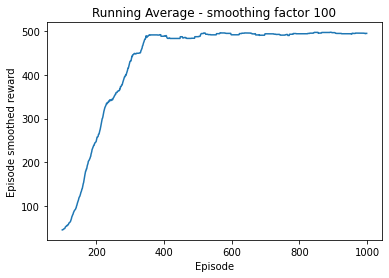

In [ ]:
# Moving average rewards plot
smooth_rew = pd.Series(statistics.episode_rewards).rolling(smooth_factor, min_periods=smooth_factor).mean()
simple_plot(smooth_rew, 'Episode', 'Episode smoothed reward', 'Running Average - smoothing factor {}'.format(smooth_factor))

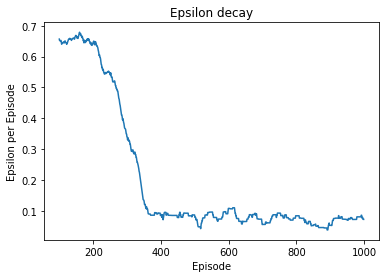

In [ ]:
# Epsilon plot
smooth_e = pd.Series(statistics.episode_epsilon).rolling(smooth_factor, min_periods=smooth_factor).mean()
simple_plot(smooth_e, 'Episode', 'Epsilon per Episode', 'Epsilon decay')

#### **Variance Analyses**

To validate the theory that, bootstrapping algorithms like Q-learning and Sarsa has a low variance, we train the model 11 times, and we compute the mean square error between the best policy found for each state. In the graph, we can see that the error is small, varing subtle values among the assays. However we got some peaks in the graph, which suggest it has a variance, but it is smaller than the others.

Train to model over 1000 episodes costs in average time 113 seconds. The space complexity of the algorithm is $O(states*actions)$.

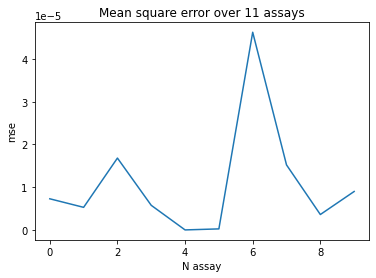

Mean time of processing: 113.03 seconds


In [ ]:
n_episode = 1000
gamma = 1
alpha = 0.2
lamb = 0.8
N0 = 10
reward_fun = 2
n_bins = 10
idx = [0, 1, 2,3]

Q_best_policy = []

running_time = []

range_ = 11

for i in range(range_):
  start = time.time()
  s = SarsaLambda(env=env, n_episode=n_episode, gamma=gamma, alpha=alpha, lamb=lamb, 
                N0=N0, reward_fun=reward_fun, n_bins=n_bins, idx=idx)
  r = s.exec_sarsa_lambda()
  best = np.argmax(r[1], axis=1)
  Q_best_policy.append(best)
  running_time.append(time.time() - start)

mse = []
for i in range(range_ - 1):

  mse.append(np.square((Q_best_policy[i] - Q_best_policy[i+1]).mean()))
    
simple_plot(mse, 'N assays', 'mse', 'Mean square error over 11 assays')
print('Mean time of processing: {:.2f}'.format(np.mean(running_time)), 'seconds')

## Linear Function Approximation

In this part, we conducted some tests on the three methods using linear function approximation. 

*   First, we did a **grid search** on different hyperparameters to select the best hyperparameters for each methods. We define the "best" by choosing the hyperparameters that achieve the highest average episode lengths for the duration of 100 episodes;
*   Second, we **visualize and compare the results** on different parameters for each algorithm;
*   Third, we anaylze the results for each algorithm and discuss the **advantages and disadvantages** of using function approximation;
*   Fourth, we compare three algorithms to disscuss the **speed and performance of convergance**.


In the process of grid search, we search for three hyperparameters: **starting learning rate $\alpha$, discounter factor $\gamma$, and reward functions.** The two reward functions we choose to compare are: 

*   reward mode 0: reward = 1; 
*   reward mode 1: reward is related to the number of steps the agent is achieving, the higher the number of steps, the higher the reward;

Both reward functions have a reward = -500 when episode ends earlier than 500 steps.


In [ ]:
def plot_all_approx(df, feature, label, smooth_factor=100, title=None):
    i = 0
    for index, row in df.iterrows():

        smooth_rew = pd.Series(row['totalsteps']).rolling(smooth_factor, min_periods=smooth_factor).mean()

        plt.plot(smooth_rew, label=label.format(feature[i]))
        i += 1

    plt.xlabel('Episode')
    plt.ylabel('Smoothed episode length')
    plt.title('Running avg - {} | SF: {}'.format(title, smooth_factor))
    plt.legend()

In [ ]:
feature_labels = {'gamma':'$γ = {:.1f}$', 
                  'lambda':'$λ = {:.1f}$', 
                  'reward_mode':'$Reward = {:.1f}$',
                  'alpha':'$α = {:.3f}$'}

In [ ]:
environment_name = 'CartPole-v1'
display = Display(visible=0, size=(1400, 900))
display.start()
N = 1000

**As the grid search takes a long time to finish, we saved the results in a pickle file and load it here.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Monte Carlo Control

#### Monte Carlo on policy

**Grid search for best hyperparameters**

In [ ]:
maximum_avg = 0
best_param = ''

params = []
totalrewards = []
totalsteps = []
durations = []
for reward_mode in [0, 1]:
  for alpha in [0.01, 0.1, 0.3]:
    for gamma in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
      env = wrap_env(gym.make(environment_name))
      ft = FeatureTransformer(env)
      mc_model = LinearModel(env, ft)
      env.reset()
      print('Running reward mode ' + str(reward_mode) + ', starting alpha:' + str(alpha) + ', gamma:' + str(gamma))
      start = time.time() # timing execution time
      mc_totalrewards, mc_totalsteps = play_many_mc(env, mc_model, gamma, alpha, policy='on', reward_mode=reward_mode, N=N, print_info=False)
      duration = time.time() - start
      param = 'rm{:.0f}alpha{:.2f}gamma{:3.1f}'.format(float(reward_mode),float(alpha),float(gamma))
      
      # save the best parameters
      run_avg = plot_running_avg(mc_totalsteps, "", plot=False)
      print("avg episode length(last 100): ", run_avg[-1])
      if run_avg[-1] > maximum_avg:
        maximum_avg = run_avg[-1]
        best_param = param

      # save all runs
      params.append(param)
      totalrewards.append(mc_totalrewards)
      totalsteps.append(mc_totalsteps)
      durations.append(duration)

mc_on_runs = {'params': params, 'totalrewards': totalrewards, 'totalsteps':totalsteps, 'durations':durations}
mc_on_df = pd.DataFrame(data = mc_on_runs)

print('Best parameters:', best_param)

In [ ]:
mc_on_df = pd.read_pickle('./drive/Shareddrives/Reinforcement_learning/ass#1/mcOnHistory.pkl')

In [ ]:
maximum_avg = 0
best_param = ''

for index, row in mc_on_df.iterrows():
    run_avg = plot_running_avg(row['totalsteps'], '', plot=False)
    print('parameters:', row['params'], ", avg episode length(last 100): ", run_avg[-1])
    if run_avg[-1] > maximum_avg:
        maximum_avg = run_avg[-1]
        best_param = row['params']

# print('Best parameters:', best_param)
best_rm = (best_param[2])
best_alpha = (best_param[8:12])
best_gamma = (best_param[17:])
print("------------------------------------------------")
print('Best Reward Mode:', best_rm)
print('Best Alpha:', best_alpha)
print('Best Gamma:', best_gamma)
print('Maximum episode length (smoothed over 100 eposides):', maximum_avg)

parameters: rm0alpha0.01gamma0.1 , avg episode length(last 100):  17.019801980198018
parameters: rm0alpha0.01gamma0.3 , avg episode length(last 100):  33.524752475247524
parameters: rm0alpha0.01gamma0.5 , avg episode length(last 100):  10.108910891089108
parameters: rm0alpha0.01gamma0.7 , avg episode length(last 100):  11.188118811881187
parameters: rm0alpha0.01gamma0.9 , avg episode length(last 100):  497.5247524752475
parameters: rm0alpha0.01gamma1.0 , avg episode length(last 100):  10.445544554455445
parameters: rm0alpha0.10gamma0.1 , avg episode length(last 100):  19.207920792079207
parameters: rm0alpha0.10gamma0.3 , avg episode length(last 100):  158.3960396039604
parameters: rm0alpha0.10gamma0.5 , avg episode length(last 100):  321.71287128712873
parameters: rm0alpha0.10gamma0.7 , avg episode length(last 100):  394.05940594059405
parameters: rm0alpha0.10gamma0.9 , avg episode length(last 100):  143.07920792079207
parameters: rm0alpha0.10gamma1.0 , avg episode length(last 100):  9

In [ ]:
best_param_index_mc_on = mc_on_df.index[mc_on_df['params'] == best_param]
# save the best parameter index for later algorithm comparison
print(best_param_index_mc_on[0])

4


In [ ]:
reward_mode = [0, 1]
alpha = [0.01, 0.1, 0.3]
gamma = [0.1, 0.3, 0.5, 0.7, 0.9, 1]

After the grid search, we find out that the best hyperparameters for monte carlo on-policy is: 

$\alpha=0.01$, $\gamma = 0.9$ and reward mode = 0.

Now we analyze the influence of each hyperparamer on the performance of algorithm. To do this, we vary the hyperparameter we intend to analyze and fix the other ones to be the best we have found from grid search.

**Gamma analysis**


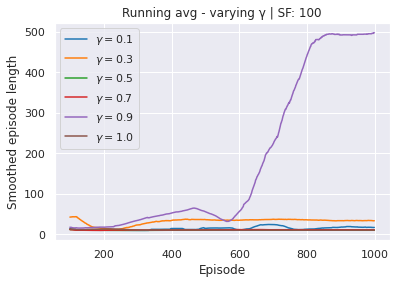

In [ ]:
# Gamma analysis
dfgamma = mc_on_df[mc_on_df.params.str.contains('^rm'+best_rm+'alpha'+best_alpha,regex=True)]
plot_all_approx(dfgamma, gamma, feature_labels['gamma'], smooth_factor = 100, title = 'varying γ')

For monte carlo on-policy control, we see that choosing the right value of $\gamma$ is crucial for solution convergence. In our testes, **only** when $\gamma = 0.9$ the algorithm converged to around 500 steps. For all other $\gamma$ values, it failed.

**Alpha analysis**


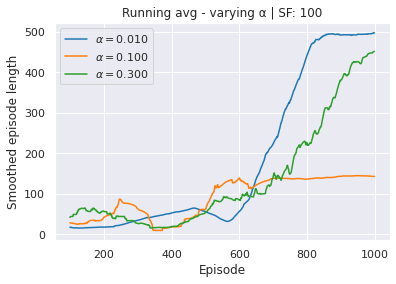

In [ ]:
# Alpha analysis 
dfalpha = mc_on_df[mc_on_df.params.str.contains('^rm'+best_rm+'.*gamma'+best_gamma+'$',regex=True)]
plot_all_approx(dfalpha, alpha, feature_labels['alpha'], smooth_factor = 100, title = 'varying α')

The learning rate used also highly influenced the quality of the achieved solution. Curiously, the best results were reached with the lowest and highest values tested ($\alpha = 0.010$ and $\alpha = 0.300$). It shows the high variance of stochastic gradient descent, and navigating it with smaller learning rates to look for the minima is beneficial. The line with smaller learning rate is not only smoother, but it reaches convergence faster than the higher learning rate run. 

**Reward mode analysis**

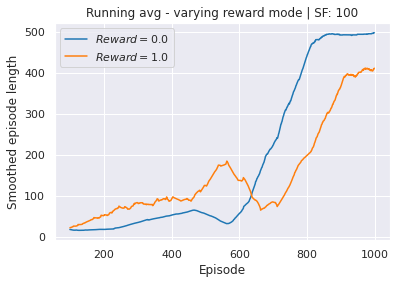

In [ ]:
# Reward mode analysis 
dfreward = mc_on_df[mc_on_df.params.str.contains('.*alpha'+best_alpha+'gamma'+best_gamma+'$',regex=True)]
plot_all_approx(dfreward, reward_mode, feature_labels['reward_mode'], smooth_factor = 100, title = 'varying reward mode')

Our expection was that reward mode 0 should work better than reward mode 1, as it encourages the agent to keep moving for more episodes. However, we see in the figure that reward mode 0 actually works better than reward mode 1. With reward mode 1, in the beginning, the algorithm learns faster, but then it diverged for some episodes then started to learn again, but did not converge to 500.

**Run the algorithm with the best hyperparameters**

In [ ]:
# Run the algorithm again with the best hyperparameters
env = wrap_env(gym.make(environment_name))
ft = FeatureTransformer(env)
mc_model = LinearModel(env, ft)
env.reset()
start = time.time() # timing execution time
mc_totalrewards, mc_totalsteps, mc_loss = play_many_mc(env, mc_model, float(best_gamma), float(best_alpha), policy = 'on', reward_mode=int(best_rm), N=N, print_info=True)
duration = time.time() - start

episode: 0 total reward: -450.0 total steps: 51 eps: 1.0 avg steps (last 100): 51.0
episode: 500 total reward: -248.0 total steps: 253 eps: 0.04467670516087703 avg steps (last 100): 398.7524752475247


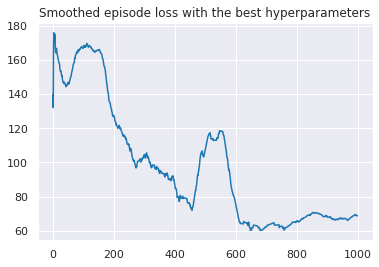

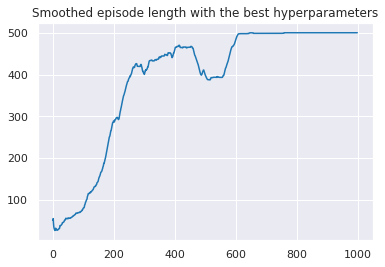

execution time: 1713.5265638828278
last 100 episodes average loss 68.78944314642304
last 100 episodes average episode length 500.0
Displaying video/openaigym.video.0.3933.video001000.mp4


In [ ]:
run_avg_loss = plot_running_avg(np.sqrt(mc_loss), 'Smoothed episode loss with the best hyperparameters', plot=True)
run_avg_steps = plot_running_avg((mc_totalsteps), 'Smoothed episode length with the best hyperparameters', plot=True)
print('execution time:', duration)
print('last 100 episodes average loss', run_avg_loss[-1])
print('last 100 episodes average episode length', run_avg_steps[-1])
env.close()
show_video()


Using the best hyperparameters for Linear Function Approximation of Monte Carlo on policy achieved convergence after 600 episodes, as shown in the plots above. The video shows the solution found for the cartpole environment. From the final running with the best parameters, we can see that the agent converged to 500 steps, and keeps it's convergence. However the cart is slowly moving to the right, indicating that the cart might eventually move out of the window.

####Monte carlo off policy

**Grid search for best hyperparameters**

In [ ]:
maximum_avg = 0
best_param = ''

params = []
totalrewards = []
totalsteps = []
durations = []
for reward_mode in [0, 1]:
  for alpha in [0.01, 0.1]:
    for gamma in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
      env = wrap_env(gym.make(environment_name))
      ft = FeatureTransformer(env)
      mc_model = LinearModel(env, ft)
      env.reset()
      print('Running reward mode ' + str(reward_mode) + ', starting alpha:' + str(alpha) + ', gamma:' + str(gamma))
      start = time.time() # timing execution time
      mc_totalrewards, mc_totalsteps = play_many_mc(env, mc_model, gamma, alpha, policy='off', reward_mode=reward_mode, N=N, print_info=False)
      duration = time.time() - start
      param = 'rm{:.0f}alpha{:.2f}gamma{:3.1f}'.format(float(reward_mode),float(alpha),float(gamma))
      
      # save the best parameters
      run_avg = plot_running_avg(mc_totalsteps, "", plot=False)
      print("avg episode length(last 100): ", run_avg[-1])
      if run_avg[-1] > maximum_avg:
        maximum_avg = run_avg[-1]
        best_param = param

      # save all runs
      params.append(param)
      totalrewards.append(mc_totalrewards)
      totalsteps.append(mc_totalsteps)
      durations.append(duration)

mc_off_runs = {'params': params, 'totalrewards': totalrewards, 'totalsteps':totalsteps, 'durations':durations}
mc_off_df = pd.DataFrame(data = mc_off_runs)

print('Best parameters:', best_param)

We ran the grid search twice to see if the best hyperparameters found were consistent.

In [ ]:
mc_off_df = pd.read_pickle('./drive/Shareddrives/Reinforcement_learning/ass#1/mcOffHistory.pkl')
mc_off_df1 = pd.read_pickle('./drive/Shareddrives/Reinforcement_learning/ass#1/mcOffHistory1.pkl')

In [ ]:
maximum_avg = 0
best_param = ''

for index, row in mc_off_df.iterrows():
    run_avg = plot_running_avg(row['totalsteps'], '', plot=False)
    print('parameters:', row['params'], ", avg episode length(last 100): ", run_avg[-1])
    if run_avg[-1] > maximum_avg:
        maximum_avg = run_avg[-1]
        best_param = row['params']

# print('Best parameters:', best_param)
best_rm = (best_param[2])
best_alpha = (best_param[8:12])
best_gamma = (best_param[17:])
print("------------------------------------------------")
print('Best Reward Mode:', best_rm)
print('Best Alpha:', best_alpha)
print('Best Gamma:', best_gamma)
print('Maximum episode length (smoothed over 100 eposides):', maximum_avg)

parameters: rm0alpha0.01gamma0.1 , avg episode length(last 100):  422.33663366336634
parameters: rm0alpha0.01gamma0.3 , avg episode length(last 100):  499.3168316831683
parameters: rm0alpha0.01gamma0.5 , avg episode length(last 100):  10.98019801980198
parameters: rm0alpha0.01gamma0.7 , avg episode length(last 100):  11.0
parameters: rm0alpha0.01gamma0.9 , avg episode length(last 100):  338.8910891089109
parameters: rm0alpha0.01gamma1.0 , avg episode length(last 100):  9.613861386138614
parameters: rm0alpha0.10gamma0.1 , avg episode length(last 100):  9.524752475247524
parameters: rm0alpha0.10gamma0.3 , avg episode length(last 100):  9.455445544554456
parameters: rm0alpha0.10gamma0.5 , avg episode length(last 100):  9.663366336633663
parameters: rm0alpha0.10gamma0.7 , avg episode length(last 100):  9.524752475247524
parameters: rm0alpha0.10gamma0.9 , avg episode length(last 100):  9.603960396039604
parameters: rm0alpha0.10gamma1.0 , avg episode length(last 100):  9.673267326732674
para

In [ ]:
best_param_index_mc_off = mc_off_df.index[mc_off_df['params'] == best_param]
print(best_param_index_mc_off[0])

1


In [ ]:
maximum_avg = 0
best_param = ''

for index, row in mc_off_df1.iterrows():
    run_avg = plot_running_avg(row['totalsteps'], '', plot=False)
    print('parameters:', row['params'], ", avg episode length(last 100): ", run_avg[-1])
    if run_avg[-1] > maximum_avg:
        maximum_avg = run_avg[-1]
        best_param = row['params']

# print('Best parameters:', best_param)
best_rm1 = (best_param[2])
best_alpha1 = (best_param[8:12])
best_gamma1 = (best_param[17:])
print("------------------------------------------------")
print('Best Reward Mode:', best_rm1)
print('Best Alpha:', best_alpha1)
print('Best Gamma:', best_gamma1)
print('Maximum episode length (smoothed over 100 eposides):', maximum_avg)

parameters: rm0alpha0.01gamma0.1 , avg episode length(last 100):  9.623762376237623
parameters: rm0alpha0.01gamma0.3 , avg episode length(last 100):  9.504950495049505
parameters: rm0alpha0.01gamma0.5 , avg episode length(last 100):  12.485148514851485
parameters: rm0alpha0.01gamma0.7 , avg episode length(last 100):  420.4950495049505
parameters: rm0alpha0.01gamma0.9 , avg episode length(last 100):  500.0
parameters: rm0alpha0.01gamma1.0 , avg episode length(last 100):  9.524752475247524
parameters: rm0alpha0.10gamma0.1 , avg episode length(last 100):  9.643564356435643
parameters: rm0alpha0.10gamma0.3 , avg episode length(last 100):  9.702970297029703
parameters: rm0alpha0.10gamma0.5 , avg episode length(last 100):  9.584158415841584
parameters: rm0alpha0.10gamma0.7 , avg episode length(last 100):  9.584158415841584
parameters: rm0alpha0.10gamma0.9 , avg episode length(last 100):  9.653465346534654
parameters: rm0alpha0.10gamma1.0 , avg episode length(last 100):  9.603960396039604
par

When we performed the grid search twice, the best parameters changed. In fact, only the best $\gamma$ changed from 0.3 to 0.9 --- a difference not to be neglected. More importantly, the parameters that performed the best in the first grid search, completely failed in the second one, achieving only $9.50$ average episode length (very far from the former $499.3$ average). This shows how stochastic some parts of this process is, and how this can affect the choice for the best parameters. 

In the following analysis, we used the **first** grid search best parameters. For each of the plots, we individually analyze the searched parameters, setting the others with the best values found. 

In [ ]:
reward_mode = [0, 1]
alpha = [0.01, 0.1]
gamma = [0.1, 0.3, 0.5, 0.7, 0.9, 1]

**Gamma analysis**


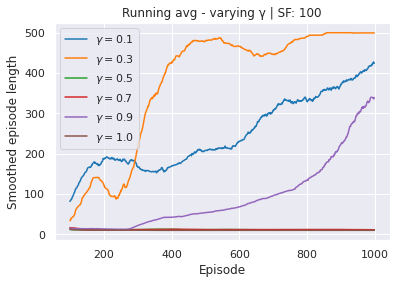

In [ ]:
# Gamma analysis
dfgamma = mc_off_df[mc_off_df.params.str.contains('^rm'+best_rm+'alpha'+best_alpha,regex=True)]
plot_all_approx(dfgamma, gamma, feature_labels['gamma'], smooth_factor = 100, title = 'varying γ')

For the discount factor $\gamma$, only $3$ values showed promising results --- including the best value found on the second grid search ($0.9$). Curiously, among this promising set, we have low and high values ($0.1, 0.3$, and $0.9$) making it difficult to analyse if the solution benefits from raising or diminishing the importance of future rewards. 

**Alpha analysis**


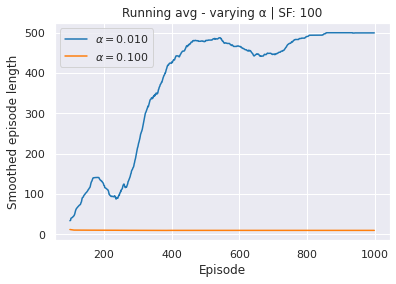

In [ ]:
# Alpha analysis 
dfalpha = mc_off_df[mc_off_df.params.str.contains('^rm'+best_rm+'.*gamma'+best_gamma+'$',regex=True)]
plot_all_approx(dfalpha, alpha, feature_labels['alpha'], smooth_factor = 100, title = 'varying α')

As in Monte Carlo on policy grid search, correctly picking $\alpha$ is crucial to the solution convergence. Again, the best results were achieved when using the lowest learning rate.

**Reward mode analysis**


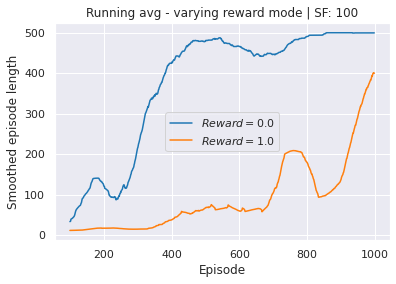

In [ ]:
# Reward mode analysis 
dfreward = mc_off_df[mc_off_df.params.str.contains('.*alpha'+best_alpha+'gamma'+best_gamma+'$',regex=True)]
plot_all_approx(dfreward, reward_mode, feature_labels['reward_mode'], smooth_factor = 100, title = 'varying reward mode')

The reward mode also have very similar behavior to monte carlo on policy grid search. Reward mode 0 achieves convergence significantly faster than reward mode 1, even though both seems to converge. 

**Run the algorithm with the best hyperparameters**

In [ ]:
# Run the algorithm again with the best hyperparameters
env = wrap_env(gym.make(environment_name))
ft = FeatureTransformer(env)
mc_model = LinearModel(env, ft)
env.reset()
start = time.time() # timing execution time
mc_totalrewards, mc_totalsteps, mc_loss = play_many_mc(env, mc_model, float(best_gamma1), float(best_alpha1), policy = 'off', reward_mode=int(best_rm1), N=N, print_info=True)
duration = time.time() - start

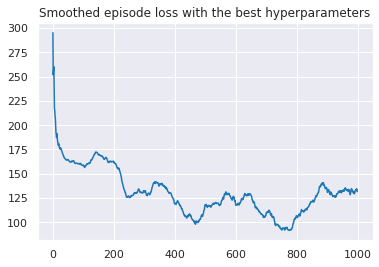

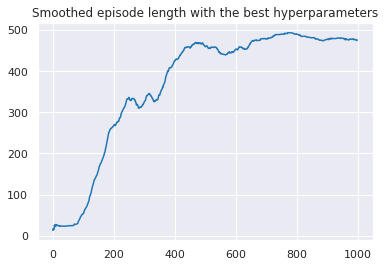

execution time: 1644.1907942295074
last 100 episodes average loss 131.63075646750679
last 100 episodes average episode length 475.58415841584156
Displaying video/openaigym.video.1.3933.video001000.mp4


In [ ]:
## Note::  calculation was wrong, did not divided by episode length, now it's fixed
run_avg_loss = plot_running_avg(np.sqrt(mc_loss/mc_totalsteps), 'Smoothed episode loss with the best hyperparameters', plot=True) 
run_avg_steps = plot_running_avg((mc_totalsteps), 'Smoothed episode length with the best hyperparameters', plot=True)
print('execution time:', duration)
print('last 100 episodes average loss', run_avg_loss[-1])
print('last 100 episodes average episode length', run_avg_steps[-1])
env.close()
show_video()

Using the best hyperparameters for Linear Function Approximation of Monte Carlo off policy achieved convergence after 700 episodes, as shown in the plots above. The video shows the solution found for the cartpole environment. From the final result running with the best parameters, we can see that the agent converged to more than 475 steps, but it jiggles around. Inerestingly, we see that the cart moves in a long range left and right, but did not move out of the window.

### Q-Learning

**Q-learning grid search**

In [ ]:
maximum_avg = 0
best_param = ''

params = []
totalrewards = []
totalsteps = []
durations = []
for reward_mode in [0, 1]:
  for alpha in [0.01, 0.1]:
    for gamma in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
      env = wrap_env(gym.make(environment_name))
      ft = FeatureTransformer(env)
      q_model = LinearModel(env, ft)
      env.reset()
      print('Running reward mode ' + str(reward_mode) + ', starting alpha:' + str(alpha) + ', gamma:' + str(gamma))
      start = time.time() # timing execution time
      q_totalrewards, q_totalsteps = play_many_ql(env, q_model, gamma, alpha, reward_mode=reward_mode, N=N, print_info=False)
      duration = time.time() - start
      param = 'rm{:.0f}alpha{:.2f}gamma{:3.1f}'.format(float(reward_mode),float(alpha),float(gamma))
      
      # save the best parameters
      run_avg = plot_running_avg(q_totalsteps, "", plot=False)
      print("avg episode length(last 100): ", run_avg[-1])
      if run_avg[-1] > maximum_avg:
        maximum_avg = run_avg[-1]
        best_param = param

      # save all runs
      params.append(param)
      totalrewards.append(q_totalrewards)
      totalsteps.append(q_totalsteps)
      durations.append(duration)

q_runs = {'params': params, 'totalrewards': totalrewards, 'totalsteps':totalsteps, 'durations':durations}
q_df = pd.DataFrame(data = q_runs)

print('Best parameters:', best_param)

In [ ]:
q_df = pd.read_pickle('./drive/Shareddrives/Reinforcement_learning/ass#1/qHistory.pkl')

Best parameters: rm0alpha0.10gamma0.7
Best parameters: rm0alpha0.10gamma0.9
Best parameters: rm1alpha0.10gamma0.9


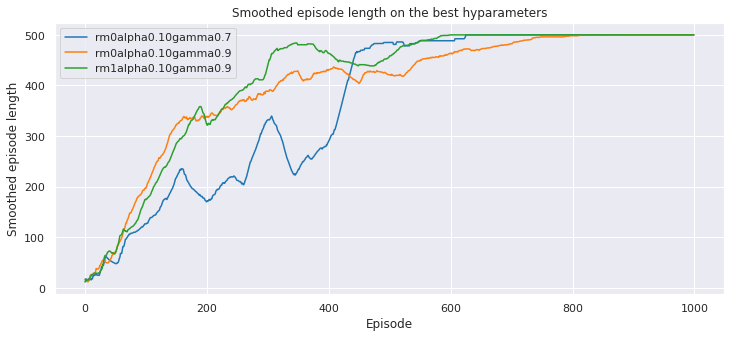

------------------------------------------------
Best Reward Mode: 1
Best Alpha: 0.10
Best Gamma: 0.9


In [ ]:
maximum_avg = 0

for index, row in q_df.iterrows():
    run_avg = plot_running_avg(row['totalsteps'], '', plot=False)
#     print('parameters:', row['params'], ", avg episode length(last 100): ", run_avg[-1])
    if run_avg[-1] > maximum_avg:
        maximum_avg = run_avg[-1]
#         best_param = row['params']

# There might exist multiple best parameters, we save and plot all of them
best_params = []
best_run_avgs = []
plt.figure(figsize=(12,5))
for index, row in q_df.iterrows():
    run_avg = plot_running_avg(row['totalsteps'], '', plot=False)
    if run_avg[-1] >= maximum_avg:
        print('Best parameters:', row['params'])
        best_params.append(row['params'])
        best_run_avgs.append(run_avg)
        plt.plot(run_avg, label=row['params'])

plt.xlabel('Episode')
plt.ylabel('Smoothed episode length')
plt.title('Smoothed episode length on the best hyparameters')
plt.legend()
plt.show()

# now we choose the best of the best by compute the summation episode length over all episodes, 
# as the best would be the one that converges the fast
best_avg = 0
best_param = ''
for i in range(len(best_run_avgs)):
    sum_avg = np.sum(best_run_avgs[i])
    if sum_avg > best_avg:
        best_avg = sum_avg
        best_param = best_params[i]
        
best_rm = (best_param[2])
best_alpha = (best_param[8:12])
best_gamma = (best_param[17:20])
print("------------------------------------------------")
print('Best Reward Mode:', best_rm)
print('Best Alpha:', best_alpha)
print('Best Gamma:', best_gamma)

In [ ]:
best_param_index_q = q_df.index[q_df['params'] == best_param]
print(best_param_index_q[0])

22


**Grid search analysis**

We can see from the figure above that Q-learning can converge to episode length 500 with different hyperparameters. To decide the best hyperparameters, we consider the speed of convergence. To compare this, we calculated the area under the smoothed episode length, which is the summation of every episode length over all episodes. The bigger the summation under the curve, the faster the algorithm converges, because it means the algorithm is learning fast since earlier episodes.

In [ ]:
reward_mode = [0, 1]
alpha = [0.01, 0.1]
gamma = [0.1, 0.3, 0.5, 0.7, 0.9, 1]

**Gamma analysis**

Similar to the Monte Carlo on policy approach, $\gamma$ = 0.9 was the best value found. Also, by varying the discount factor from 0.5 to 0.9, the model reaches promising results. In contrast to the tabular $Q$-learning, using the maximum discount factor is as bad as using smaller values. It suggests that for Q-learning with linear approximation estimations, future rewards are relevant. However, dismiss some future knowledge is better than consider the whole.

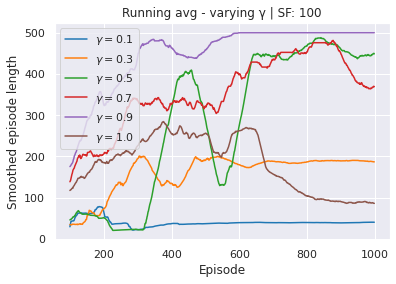

In [ ]:
# Gamma analysis
dfgamma = q_df[q_df.params.str.contains('^rm'+best_rm+'alpha'+best_alpha,regex=True)]
plot_all_approx(dfgamma, gamma, feature_labels['gamma'], smooth_factor = 100, title = 'varying γ')

**Alpha analysis**

In contrast to Monte Carlo Off-policy linear approximation approach, both learning rate values produce excellent improvements over time. In this specific case, the highest learning rate ($0.10$) achieved convergence faster. Although the other also tends to the converge to the optimum, it did not converge with 1000 episodes. The reason is that it takes little steps over time, requiring more iterations.

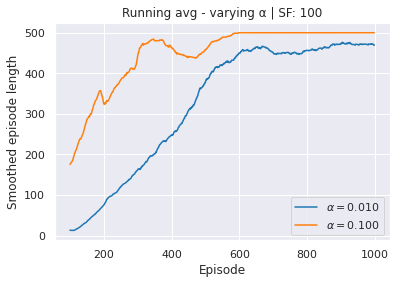

In [ ]:
# Alpha analysis 
dfalpha = q_df[q_df.params.str.contains('^rm'+best_rm+'.*gamma'+best_gamma+'$',regex=True)]
plot_all_approx(dfalpha, alpha, feature_labels['alpha'], smooth_factor = 100, title = 'varying α')

**Reward analysis**

Here, both rewards function converges to the optimum value with similar speed. Curiously, they improved with subtle differences. Nevertheless, the reward mode-based on checkpoints converges a bit faster.

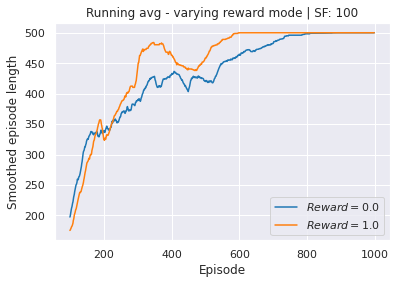

In [ ]:
# Reward mode analysis 
dfreward = q_df[q_df.params.str.contains('.*alpha'+best_alpha+'gamma'+best_gamma+'$',regex=True)]
plot_all_approx(dfreward, reward_mode, feature_labels['reward_mode'], smooth_factor = 100, title = 'varying reward mode')

**Run the algorithm with the best hyperparameters**

In [ ]:
# Run the algorithm again with the best hyperparameters
env = wrap_env(gym.make(environment_name))
ft = FeatureTransformer(env)
q_model = LinearModel(env, ft)
env.reset()
start = time.time() # timing execution time
q_totalrewards, q_totalsteps, q_loss = play_many_ql(env, q_model, float(best_gamma), float(best_alpha), reward_mode=int(best_rm), N=N, print_info=True)
duration = time.time() - start

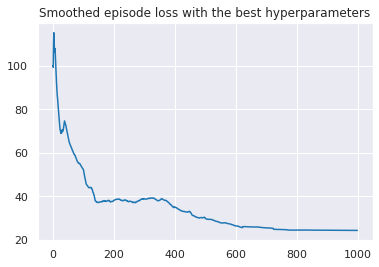

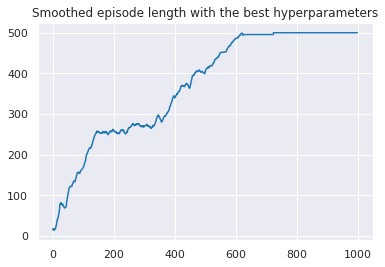

execution time: 1664.8989126682281
last 100 episodes average loss 24.3614025436488
last 100 episodes average episode length 500.0
Displaying video/openaigym.video.3.3933.video001000.mp4


In [ ]:
run_avg_loss = plot_running_avg(np.sqrt(q_loss), 'Smoothed episode loss with the best hyperparameters', plot=True)
run_avg_steps = plot_running_avg((q_totalsteps), 'Smoothed episode length with the best hyperparameters', plot=True)
print('execution time:', duration)
print('last 100 episodes average loss', run_avg_loss[-1])
print('last 100 episodes average episode length', run_avg_steps[-1])
env.close()
show_video()

Unlike the result from Monte carlo on-policy and off-policy control methods, where the cart movement were not very stable, for Q-learning, the cart moves steadily in a small range.

### SARSA(λ)

**Sarsa($\lambda$) grid search**

In [ ]:
maximum_avg = 0
best_param = ''

params = []
totalrewards = []
totalsteps = []
durations = []
for reward_mode in [0, 1]:
  for alpha in [0.01, 0.1]:
    for gamma in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
      for lbd in np.arange(0.0, 1.2, 0.2):
        env = wrap_env(gym.make(environment_name))
        ft = FeatureTransformer(env)
        sarsa_model = SarsaModel(env, ft)
        env.reset()
        print('Running reward mode ' + str(reward_mode) + ', starting alpha:' + str(alpha) + ', gamma:' + str(gamma) + ', lambda:' + str(lbd))
        start = time.time() # timing execution time
        sarsa_totalrewards, sarsa_totalsteps = play_many_sarsa(env, sarsa_model, gamma, lbd, alpha, reward_mode=reward_mode, N=N, print_info=False)
        duration = time.time() - start
        param = 'rm{:.0f}alpha{:.2f}gamma{:3.1f}lambda{:3.1f}'.format(float(reward_mode),float(alpha),float(gamma),float(lbd))
        
        # save the best parameters
        run_avg = plot_running_avg(sarsa_totalsteps, "", plot=False)
        print("avg episode length(last 100): ", run_avg[-1])
        if run_avg[-1] > maximum_avg:
          maximum_avg = run_avg[-1]
          best_param = param

        # save all runs
        params.append(param)
        totalrewards.append(sarsa_totalrewards)
        totalsteps.append(sarsa_totalsteps)
        durations.append(duration)

sarsa_runs = {'params': params, 'totalrewards': totalrewards, 'totalsteps':totalsteps, 'durations':durations}
sarsa_df = pd.DataFrame(data = sarsa_runs)

print('Best parameters:', best_param)

In [ ]:
sarsa_df = pd.read_pickle('./drive/Shareddrives/Reinforcement_learning/ass#1/sarsaHistory.pkl')

Best parameters: rm0alpha0.10gamma0.5lambda0.4
Best parameters: rm0alpha0.10gamma0.7lambda0.0
Best parameters: rm0alpha0.10gamma0.7lambda0.2
Best parameters: rm0alpha0.10gamma0.9lambda0.2
Best parameters: rm0alpha0.10gamma1.0lambda0.0
Best parameters: rm0alpha0.10gamma1.0lambda0.4
Best parameters: rm1alpha0.01gamma0.5lambda1.0
Best parameters: rm1alpha0.01gamma0.7lambda0.6
Best parameters: rm1alpha0.01gamma0.9lambda0.0
Best parameters: rm1alpha0.01gamma0.9lambda0.6
Best parameters: rm1alpha0.10gamma0.5lambda0.8
Best parameters: rm1alpha0.10gamma0.7lambda0.0
Best parameters: rm1alpha0.10gamma0.7lambda0.2
Best parameters: rm1alpha0.10gamma0.9lambda0.4
Best parameters: rm1alpha0.10gamma0.9lambda0.6


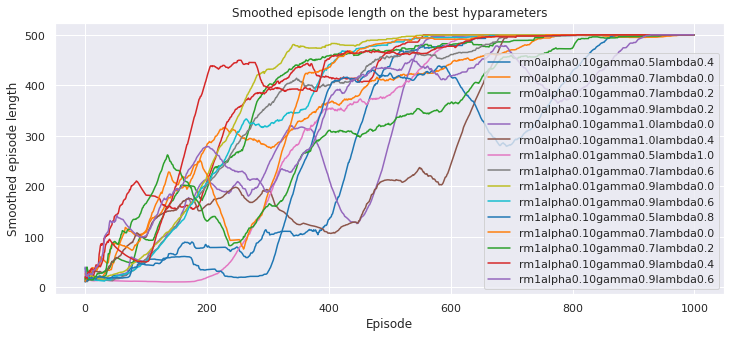

------------------------------------------------
Best Reward Mode: 1
Best Alpha: 0.10
Best Gamma: 0.9
Best Lambda: 0.4


In [ ]:
maximum_avg = 0

for index, row in sarsa_df.iterrows():
    run_avg = plot_running_avg(row['totalsteps'], '', plot=False)
#     print('parameters:', row['params'], ", avg episode length(last 100): ", run_avg[-1])
    if run_avg[-1] > maximum_avg:
        maximum_avg = run_avg[-1]
#         best_param = row['params']

# There might exist multiple best parameters, we save and plot all of them
best_params = []
best_run_avgs = []
plt.figure(figsize=(12,5))
for index, row in sarsa_df.iterrows():
    run_avg = plot_running_avg(row['totalsteps'], '', plot=False)
    if run_avg[-1] >= maximum_avg:
        print('Best parameters:', row['params'])
        best_params.append(row['params'])
        best_run_avgs.append(run_avg)
        plt.plot(run_avg, label=row['params'])

plt.xlabel('Episode')
plt.ylabel('Smoothed episode length')
plt.title('Smoothed episode length on the best hyparameters')
plt.legend()
plt.show()

# now we choose the best of the best by compute summation of episode length over all episodes, 
# as the best would be the one that converges the fast
best_avg = 0
best_param = ''
for i in range(len(best_run_avgs)):
    sum_avg = np.sum(best_run_avgs[i])
    if sum_avg > best_avg:
        best_avg = sum_avg
        best_param = best_params[i]
        
best_rm = (best_param[2])
best_alpha = (best_param[8:12])
best_gamma = (best_param[17:20])
best_lambda = (best_param[26:])
print("------------------------------------------------")
print('Best Reward Mode:', best_rm)
print('Best Alpha:', best_alpha)
print('Best Gamma:', best_gamma)
print('Best Lambda:', best_lambda)

In [ ]:
best_param_index_sarsa = sarsa_df.index[sarsa_df['params'] == best_param]
print(best_param_index_sarsa[0])

134


**Grid search analysis**

Similar to Q-learning, we can see from the figure above that sarsa($\lambda$) can converge to episode length 500 with different hyperparameters. To decide the best hyperparameters, we consider the speed of convergence. To compare this, we calculated the area under the smoothed episode length, which is the summation of every episode length over all episodes. The bigger the summation under the curve, the faster the algorithm converges, because it means the algorithm is learning fast since earlier episodes.

In [ ]:
reward_mode = [0, 1]
alpha = [0.01, 0.1]
gamma = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
lbd = np.arange(0.0, 1.2, 0.2)

**Lambda analysis**

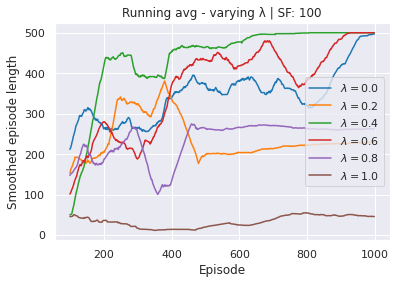

In [ ]:
# Lambda analysis
dlambda = sarsa_df[sarsa_df.params.str.contains('^rm'+best_rm+'alpha'+best_alpha+'gamma'+best_gamma,regex=True)]
plot_all_approx(dlambda, lbd, feature_labels['lambda'], smooth_factor = 100, title = 'varying λ')

Changing $\lambda$ highly affects the quality of the solution found, and the speed of convergence. The best solution found is when $\lambda = 0.4$, which is consistent with the tabular sarsa method. When $\lambda = 0$, it is similar with Q-learing method, slowing the convergence. When $\lambda = 1.0$, it is on par with monte carlo on-polocy method, and as expected, did not lead to convergence as monte carlo is very sentive to hyperparameters.

**Gamma analysis**

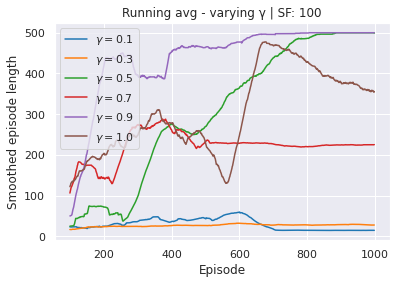

In [ ]:
# Gamma analysis
dfgamma = sarsa_df[sarsa_df.params.str.contains('^rm'+best_rm+'alpha'+best_alpha+'gamma'+'.*lambda'+best_lambda+'$',regex=True)]
plot_all_approx(dfgamma, gamma, feature_labels['gamma'], smooth_factor = 100, title = 'varying γ')

Varying the discount factor $\gamma$ also highly affected the convergence of solutions. In this case, higher values of $\gamma$ (that make future rewards more significant) are beneficial to the solution. The exception is $\gamma$ = 0.5, which also achieved very good performance.

**Alpha analysis**

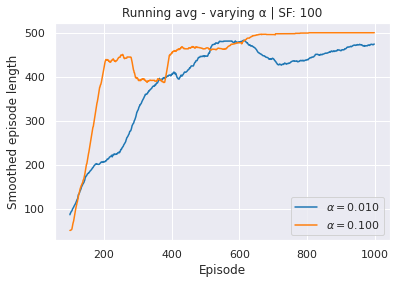

In [ ]:
# Alpha analysis 
dfalpha = sarsa_df[sarsa_df.params.str.contains('^rm'+best_rm+'.*gamma'+best_gamma+'lambda'+best_lambda+'$',regex=True)]
plot_all_approx(dfalpha, alpha, feature_labels['alpha'], smooth_factor = 100, title = 'varying α')

Among the tested step-size $\alpha$ values, there were not much difference in the quality of the solution reached. As expected, a higher step-size reached the convergence point faster. 

**Lambda analysis**

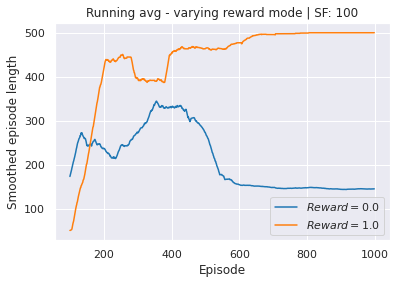

In [ ]:
# Reward mode analysis 
dfreward = sarsa_df[sarsa_df.params.str.contains('.*alpha'+best_alpha+'gamma'+best_gamma+'lambda'+best_lambda+'$',regex=True)]
plot_all_approx(dfreward, reward_mode, feature_labels['reward_mode'], smooth_factor = 100, title = 'varying reward mode')

Differently from the linear approximation for Monte Carlo methods, the reward mode for SARSA highly affected the quality of the solution. Using reward mode 1, where the reward linearly increases as the agent is able to balance the cartpole for longer periods, was crucial to reach convergence.

**Lambda analysis**

episode: 0 total reward: -481 total steps: 20 eps: 1.0 avg steps (last 100): 20.0
episode: 500 total reward: 2184 total steps: 355 eps: 0.04467670516087703 avg steps (last 100): 386.0


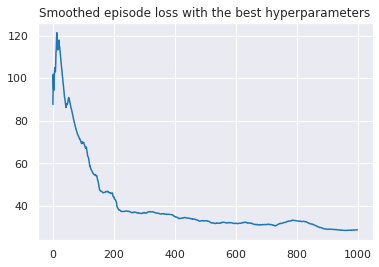

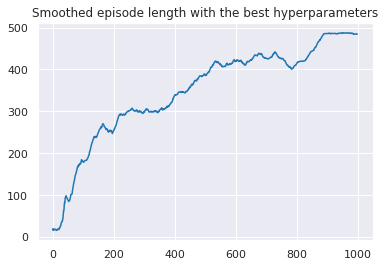

execution time: 1593.6294033527374
last 100 episodes average loss 28.724762510113404
last 100 episodes average episode length 484.63366336633663
Displaying video/openaigym.video.3.6545.video001000.mp4


In [ ]:
# Run the algorithm again with the best hyperparameters
env = wrap_env(gym.make(environment_name))
ft = FeatureTransformer(env)
sarsa_model = SarsaModel(env, ft)
env.reset()
start = time.time() # timing execution time
sarsa_totalrewards, sarsa_totalsteps, sarsa_loss = play_many_sarsa(env, sarsa_model, float(best_gamma), float(best_lambda), float(best_alpha), reward_mode=int(best_rm), N=N, print_info=True)
duration = time.time() - start
run_avg_loss = plot_running_avg(np.sqrt(sarsa_loss), 'Smoothed episode loss with the best hyperparameters', plot=True)
run_avg_steps = plot_running_avg((sarsa_totalsteps), 'Smoothed episode length with the best hyperparameters', plot=True)
print('execution time:', duration)
print('last 100 episodes average loss', run_avg_loss[-1])
print('last 100 episodes average episode length', run_avg_steps[-1])
env.close()
show_video()


Using the best hyperparameters for Linear Function Approximation of Monte Carlo on policy achieved convergence after 900 episodes, as shown in the plots above. The video shows the solution found for the cartpole environment. Interestingly, the video shows similar behavior as the one from Monte Carlo off-policy, which is that the cart moves in a wide range from left to right, but does not seem to move off the window.

### Compare the three LFA methods

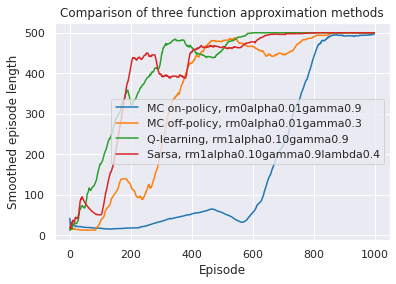

In [ ]:
avg_mc_on = plot_running_avg(mc_on_df.totalsteps[best_param_index_mc_on[0]],'', plot=False)
avg_mc_off = plot_running_avg(mc_off_df.totalsteps[best_param_index_mc_off[0]],'', plot=False)
avg_ql = plot_running_avg(q_df.totalsteps[best_param_index_q[0]],'', plot=False)
avg_sarsa = plot_running_avg(sarsa_df.totalsteps[best_param_index_sarsa[0]],'', plot=False)

plt.plot(avg_mc_on, label='MC on-policy, {}'.format(mc_on_df.params[best_param_index_mc_on[0]]))
plt.plot(avg_mc_off, label='MC off-policy, {}'.format(mc_off_df.params[best_param_index_mc_off[0]]))
plt.plot(avg_ql, label='Q-learning, {}'.format(q_df.params[best_param_index_q[0]]))
plt.plot(avg_sarsa, label='Sarsa, {}'.format(sarsa_df.params[best_param_index_sarsa[0]]))

plt.xlabel('Episode')
plt.ylabel('Smoothed episode length')
plt.title('Comparison of three function approximation methods')
plt.legend()
plt.show()

In this part, we compare the best results of three LFA methods. From the above figure, we have the following observation:

*   Monte carlo methods uses small learning rate $\alpha$ and converges slower than Q-learning and sarsa;
*   Q-learning and sarsa have very similar speed of convergene, and best the learning rate $\alpha$ and $\gamma$ are also the same;
*   Except for monte carlo off-policy, the other three methods all have the same best discount factor $\gamma = 0.9$, in fact, monte carlo off-policy second run of best parameters also found this $\gamma$ value.


### Conclusion on Linear Function Approximation

To conclusion, we list some advantages and disadvantages of LFA methods. (For more detailed discussion on the comparison of tabular methods and LFA methods, please refer to the Discussion section.)

**Advantages**:

*   Better convergence with proper features
*   Smaller space complexity (O(features))

**Disadvantages**

*   Difficult to engineer feature transformer
*   SGD is not efficient for learning



# Discussion

### Relationship between SARSA($\lambda$) and Monte Carlo
---
SARSA and Monte Carlo are theoretically equal when $\lambda = 1$. We show that in practice, the Mean Squared Error between SARSA’s ($\lambda = 1.0$) and Monte Carlo’s Q tables are the smallest among different $\lambda$ values.

In [ ]:
# Best Monte Carlo against best Sarsa
num_episodes = 1000
mc = MonteCarlo(env, num_bins=10, num_episodes=num_episodes, reward_mode=1, N0=100)
mc.exec()

In [ ]:
mses = []
for l in np.arange(0,1.2, 0.2):

  s = SarsaLambda(env=env, n_episode=num_episodes, gamma=1, alpha=0.2, lamb=l, N0=10, reward_fun=0, n_bins=10)
  _ = s.exec_sarsa_lambda()
  mse = []
  for q in s.Q_mse:

    mse.append(np.square((mc.Q - q).mean()))

  mses.append(mse)

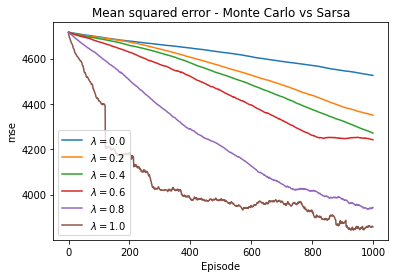

In [ ]:
feature_names = np.arange(0,1.2, 0.2)

plot_mse(mses, features=feature_names, title='Mean squared error - Monte Carlo vs Sarsa')  

<a name="n0-eval"></a>
### N0 evaluation
$N0$ is a constant used for calculating the $\epsilon$ value in the $\epsilon$-greedy function. It weights the selection of greedy or random actions in the current state. As shown in the plot below, the higher the $N0$, the longer it will take for our agent to greedy select the action to be taken.

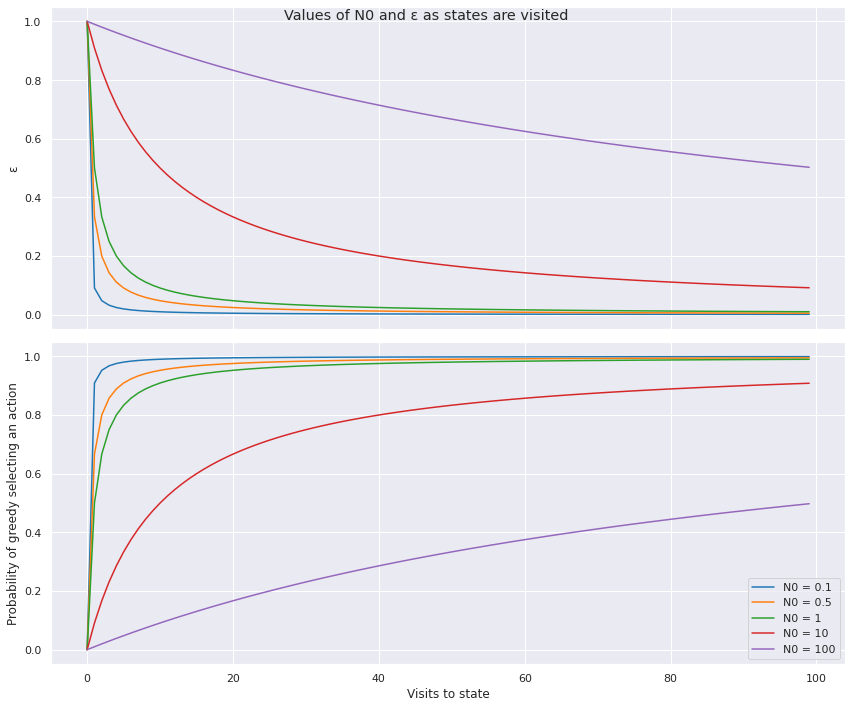

In [ ]:
fig, axis = plt.subplots(2, figsize=(12,10), sharex=True)
fig.suptitle('Values of N0 and ε as states are visited')
possible_N0s = [0.1, 0.5, 1, 10, 100]
number_of_visits = np.arange(0, 100, 1)

for value in possible_N0s:
  N0_evolution = value / (value + number_of_visits)
  axis[0].plot(N0_evolution, label=f'N0 = {value}')
  axis[1].plot(1 - N0_evolution, label=f'N0 = {value}')
axis[0].set(ylabel='ε')
axis[1].set(ylabel='Probability of greedy selecting an action')
axis[-1].set(xlabel='Visits to state')
plt.legend()
fig.tight_layout()
plt.show(fig)

Intuitivelly, the value of $N0$ that achieves the highest number of steps is 10, since it allows the agent to do a better exploration of possible actions. The value of 10 allows the agent to only greedy select the next action with higher probability after it visited the state around 10 times, while lower values of $N0$ prioritize much more the greedy selection.

## Comparing Tabular Methods

Number of possible states: 10,000


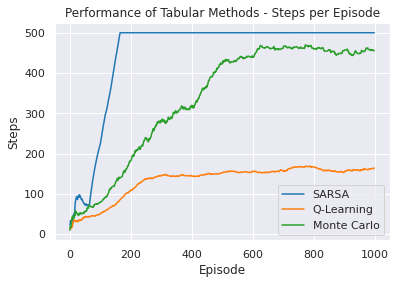

In [ ]:
# Best Monte Carlo
env = wrap_env(gym.make(environment_name))

num_episodes = 1000
mc = MonteCarlo(env, num_bins=10, num_episodes=num_episodes, reward_mode=1, N0=10, gamma=1.0)
mc.exec()

# Best SARSA
env = wrap_env(gym.make(environment_name))

n_episode = 1000
gamma = 1
alpha = 0.2
lamb = 0.8
N0 = 10
reward_fun = 2
n_bins = 10
idx = [2,3]
s = SarsaLambda(env=env, n_episode=n_episode, gamma=gamma, alpha=alpha, lamb=lamb, 
                N0=N0, reward_fun=reward_fun, n_bins=n_bins, idx=idx)
stats, Q = s.exec_sarsa_lambda()
ep_size  = stats.episode_size

# Best Q-Learning
env = wrap_env(gym.make(environment_name))

def pole_angle_based_reward(steps, observation, max_angle=3):
  pole_angle = observation[2]
  angle = max_angle * 2 * math.pi / 360
  if pole_angle < -angle or pole_angle > angle:
    return -200
  else:
    return 100


def high_penalty(steps, max_steps=500):
  if steps < max_steps - 1:
    return -max_steps
  else:
    return 0


# additional_reward_fn = pole_angle_based_reward
additional_reward_fn = None
finish_bonus_fn = high_penalty
gamma = 0.9
high_q = 1
low_q = 0
max_boundary_values = [(-2.5, 2.5), (-3.2, 3.2), (-0.3, 0.3), (-3.7, 3.7)]
n_bins = 10
#observations_to_use = [1, 3]
observations_to_use = [0, 1, 2, 3]
N0 = 10
info_for_last_eps = 100
max_episodes = 1_000
max_steps = 1_000
print_every_n_eps = 2_000


best_q_learning_agent = QLearning(env, max_episodes=max_episodes, max_steps=max_steps,
                                  max_boundary_values=max_boundary_values, n_bins=n_bins, N0=N0, gamma=gamma,
                                  additional_reward_fn=additional_reward_fn, finish_bonus_fn=finish_bonus_fn,
                                  low_q=low_q, high_q=high_q, observations_to_use=observations_to_use,
                                  name='Best Q-Learning Agent')
run_q_agent(best_q_learning_agent, max_episodes=max_episodes, print_every_n_eps=print_every_n_eps,
            info_for_last_eps=info_for_last_eps)

tabular_dict = {'SARSA' : ep_size, 'Q-Learning' : best_q_learning_agent.steps_per_episode, 'Monte Carlo' : mc.stepHistory}
multiple_plot([(value, str(key)) for key, value in tabular_dict.items()], 'Episode', 'Steps', 'Performance of Tabular Methods - Steps per Episode')


Here, we use the best hyperparameters found individually for each method, and plot them together, showing the running average of steps (considering 100 episodes) per episode achieved. 
Sarsa achieved the best performance among the Tabular algorithms implemented considering the hyperparameters used in the exploratory experiments. The high variance that surrounded our experiments throughout this project, makes it impossible to set the best method for Cartpole. However, it is clear that Q-learning did not work well in this case, placing last in the comparisons we've made. Q-learning and Sarsa are similar algorithms since both bootstrap the learning process by using estimated values. However, the main difference between these two approaches is that Sarsa interacts with the environment during it learns the optimal value function. Besides that, using eligibility traces, the model variance decreases significantly.

The stochasticity is present particularly in the epsilon-greedy policy, which takes a parameter $N0$. We show that $N0$ highly affects the chance of performing a random action instead of using the best learned movement (see the [N0 evaluation](#N0-eval)).

For all tabular methods, in our hyperparameter search, $N0 = 10$ was selected and it seems to provide a good balance between exploration and exploitation. 

## Tabular Monte Carlo vs LFA Monte Carlo (on-policy)

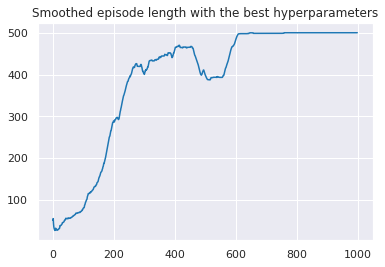


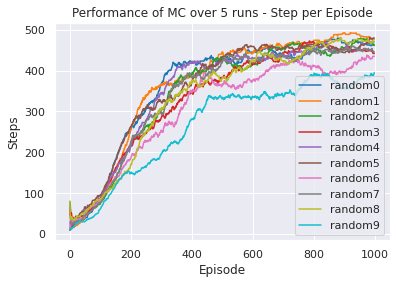

When comparing the linear approximation (left) with the tabular on-policy monte carlo (right), we can see that the performance is similar. Both are able to converge, but the approximation has an edge, since it seems to reach a more stable end at 500 steps, and it reachs it quicker, after around 600 episodes.
Both suffer from instability from the natural stochastic nature of monte carlo methods.

The core difference is the time necessary to run the experiment. The linear approximation takes $1,713$ seconds to run, and the tabular version takes around $80$ seconds. 

Another difference is how each method has access to the environment information. The linear approximation transforms the 4 observation attributes to 4,000 features, which are used to learn the weights of the approximator. The tabular method just put each reading from the environment into bins for the discretization. Thus, the inputs for the linear approximation method are richer and can transmit more information from the environment to the control system.



## Tabular Q-Learning vs LFA Q-Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

q_df=pd.read_pickle('./drive/Shareddrives/Reinforcement_learning/ass#1/qHistory.pkl')
q_best_totalsteps = q_df.totalsteps[22]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plot_q_learning_steps(method1, name1, method2, name2, figsize=(12, 5), smoothing_window=100):
  plt.figure(figsize=figsize)
  lengths1_smoothed = pd.Series(method1).rolling(smoothing_window, min_periods=smoothing_window).mean()
  lengths2_smoothed = pd.Series(method2).rolling(smoothing_window, min_periods=smoothing_window).mean()
  plt.plot(lengths1_smoothed, label=name1)
  plt.plot(lengths2_smoothed, label=name2)
  plt.xlabel('Episodes')
  plt.ylabel('Steps')
  plt.title(f'Steps per episode')
  plt.legend()
  plt.show()

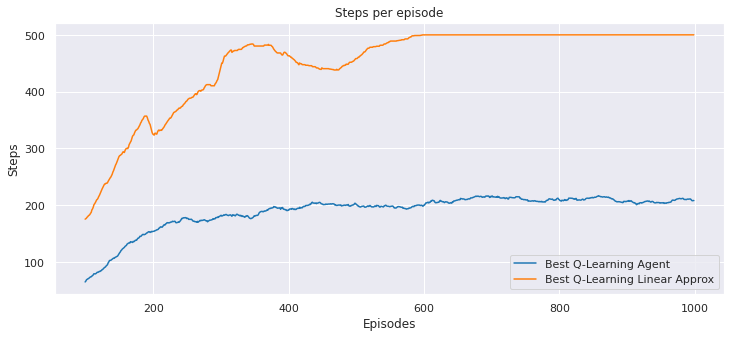

In [ ]:
plot_q_learning_steps(best_q_learning_agent.steps_per_episode, best_q_learning_agent.name, q_best_totalsteps, 'Best Q-Learning Linear Approx')

As we can clearly see, the linear approximator Q-learning function performed much better than the regular Q-learning agent. We have several hypothesis on why these two solutions are not close as presumably they should be. First, regarding the learning rate, the tabular agent uses a time-varying scalar step-size learning rate of $\alpha_{t} = 1 / N(s_{t},a_{t})$. This means that the learning rate decreases as that specific action is selected when in that specific state. In contrast, the linear approximation solution uses a starting learning rate of 0.1, which decreases 0.001 every 100 episodes. 



Also, for the tabular agent, the $\epsilon$ value is state dependent, meaning that it is calculated for every state, and it will decrease the more that state is visited. Using the $N0 = 10$ means that the greedy selection of action will happen with probability larger than 50% only after that state was visited more than 10 times. Because of the difference in learning rate decay and epsilon decay, the tabular method may be exploring more state-action pairs thus makes it slow to converge.

## Tabular Sarsa vs LFA Sarsa

<img src = " 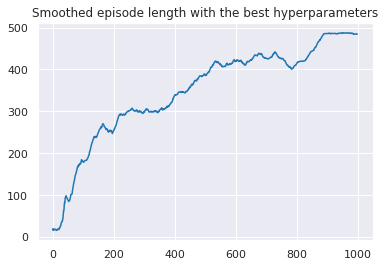">
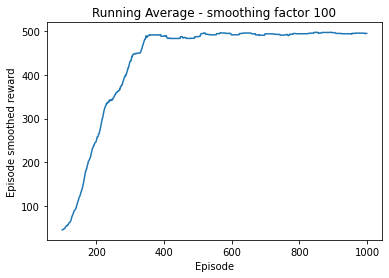

**Important:** To make sure the comparison uses the same kind of feature, both graphs show the number of steps taken (y) per episode (x), despise the name presented in the axis.

When we compare the linear approximation (left) with the tabular Sarsa lambda with eligibility traces (right), both reach the optimum value function. However, the tabular approach converges way faster. The learning process of the linear approximator is more unstable than the other until the last episodes. We believe it happens because probably the model learned to visite the same set of states in a loop, then the variance is smaller. 

Another point that we need to consider is the way the environment is understood. In tabular approaches, we have many constraints to precisely describe all information from the states. In contrast, for linear approximators, the discrimination of the observation attributes is better. With that in mind, it might require more iterations to get stable. 

A significant difference between these two methods is the time needed to train the learning algorithm. The linear approximation takes 1593 seconds to run, and tabular sarsa takes 113 seconds.

Summarizing, the main advantages of tabular sarsa over linear approximation is the running time and fast convergence. On the other hand, linear approximator tends to be more precise. Especially, concerning environmental information discrimination, which contributes to having a better exploitation rate.
